In [1]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib
import matplotlib.pyplot as plt
from torch.distributions.constraints import positive

import logging
import os

#import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy

import pyro
import ssms
import lanfactory
#torch.set_default_dtype(torch.float64)
torch.set_default_dtype(torch.float32)

from lanfactory.trainers.torch_mlp import TorchMLP 

import lanfactory
import ssms

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(9)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Define DDM simulator

In [3]:
import ssms
def sim_wrap(theta = torch.zeros(0), model = 'ddm'):
    theta = theta.numpy().astype(np.float32)
    out = ssms.basic_simulators.simulator(theta = theta,
                                          model = model,
                                          n_samples = 1,
                                          delta_t = 0.001,
                                          max_t = 20.0,
                                          no_noise = False,
                                          bin_dim = None,
                                          bin_pointwise = False)
    
    return torch.tensor(np.hstack([out['rts'].astype(np.float32), out['choices'].astype(np.float32)]))

# Load torch network

In [4]:
class LoadTorchMLP:
    def __init__(self, 
                 model_file_path = None,
                 network_config = None,
                 input_dim = None):
        
        ##torch.backends.cudnn.benchmark = True
        self.dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model_file_path = model_file_path
        self.network_config = network_config
        self.input_dim = input_dim
        
        self.net = lanfactory.trainers.torch_mlp.TorchMLP(network_config = self.network_config,
                                                          input_shape = self.input_dim,
                                                          generative_model_id = None)
        self.net.load_state_dict(torch.load(self.model_file_path))
        self.net.to(self.dev)

    # AF-TODO: Seemingly LoadTorchMLPInfer is still not callable !
    @torch.no_grad()
    def __call__(self, x):
        return self.net(x)

    @torch.no_grad()
    def predict_on_batch(self, x = None):
        return self.net(torch.from_numpy(x).to(self.dev)).cpu().numpy()

In [5]:
class CustomTorchMLP:
    def __init__(self, state_dict, network_config):
        self.weights = []
        self.biases = []
        self.activations = deepcopy(network_config['activations'])
        self.net_depth = len(self.activations)
        self.state_dict = state_dict
        cnt = 0
        for obj in self.state_dict:
            if 'weight' in obj:
                self.weights.append(deepcopy(self.state_dict[obj]).T)
            elif 'bias' in obj:
                self.biases.append(torch.unsqueeze(deepcopy(self.state_dict[obj]), 0))
                
    def forward(self, input_tensor):
        tmp = input_tensor
        for i in range(0, self.net_depth - 1, 1):
            tmp = torch.tanh(torch.add(torch.matmul(tmp, self.weights[i]), self.biases[i]))
        tmp = torch.add(torch.matmul(tmp, self.weights[self.net_depth - 1]), self.biases[self.net_depth - 1])
        return tmp

In [7]:
class CustomTorchMLPMod(torch.nn.Module):
    def __init__(self, state_dict, network_config):
        super(CustomTorchMLPMod, self).__init__()
        self.weights = []
        self.biases = []
        self.activations = deepcopy(network_config['activations'])
        self.net_depth = len(self.activations)
        self.state_dict = state_dict
        cnt = 0
        for obj in self.state_dict:
            if 'weight' in obj:
                self.weights.append(deepcopy(self.state_dict[obj]).T)
            elif 'bias' in obj:
                self.biases.append(torch.unsqueeze(deepcopy(self.state_dict[obj]), 0))
        #super().__init
        
    def forward(self, input_tensor):
        tmp = input_tensor
        for i in range(0, self.net_depth - 1, 1):
            tmp = torch.tanh(torch.add(torch.matmul(tmp, self.weights[i]), self.biases[i]))
        tmp = torch.add(torch.matmul(tmp, self.weights[self.net_depth - 1]), self.biases[self.net_depth - 1])
        return tmp

In [8]:
# Model
from copy import deepcopy
model = "ddm" # for now only DDM (once we have choice probability models --> all models applicable)
model_config = ssms.config.model_config[model].copy() # convenience

In [9]:
# # Load torch net ----------------
network_config = pickle.load(open('nets/d27193a4153011ecb76ca0423f39a3e6_ddm_torch__network_config.pickle', 'rb'))

print(network_config)

# Initialize network class
torch_net = TorchMLP(network_config = network_config,
                     input_shape = len(model_config['params']) + 2,
                     generative_model_id = None)

# Load weights and biases
torch_net.load_state_dict(torch.load('nets/d27193a4153011ecb76ca0423f39a3e6_ddm_torch_state_dict.pt', 
                          map_location=torch.device('cpu')))

# Initialize custom pytorch network
# custom_torch_net = CustomTorchMLP(torch_net.state_dict(), 
#                                   network_config)

custom_torch_net = CustomTorchMLPMod(torch_net.state_dict(), 
                                     network_config)
custom_torch_net.eval()


{'layer_types': ['dense', 'dense', 'dense', 'dense'], 'layer_sizes': [100, 100, 100, 1], 'activations': ['tanh', 'tanh', 'tanh', 'linear'], 'loss': 'huber', 'callbacks': ['checkpoint', 'earlystopping', 'reducelr'], 'model_id': 'ddm'}
tanh
tanh
linear


CustomTorchMLPMod()

In [ ]:
custom_torch_net.weights[0].dtype

In [ ]:
# Model
from copy import deepcopy
model = "ddm" # for now only DDM (once we have choice probability models --> all models applicable)
model_config = ssms.config.model_config[model].copy() # convenience

In [ ]:
# Simplest way of doing it

network_config = pickle.load(open('hddm_torch_models/torch_models/d27193a4153011ecb76ca0423f39a3e6_ddm_torch__network_config.pickle', 'rb'))

mynet_simple = lanfactory.trainers.torch_mlp.TorchMLP(network_config = network_config,
                                                      input_shape = 6)
mynet_simple.load_state_dict(torch.load('hddm_torch_models/torch_models/d27193a4153011ecb76ca0423f39a3e6_ddm_torch_state_dict.pt'))

In [55]:
import time
net_in = torch.rand(1000,6)
start = time.time()
for i in range(1000):
    with torch.no_grad():
        out = mynet_simple(net_in)
print((time.time() - start) / 1000)

0.0017741928100585937


In [56]:
import time
start = time.time()
for i in range(1000):
    out = mynet_simple(net_in)
print((time.time() - start) / 1000)

0.0018312814235687256


In [39]:
time.time()

1657553403.594798

In [8]:
y = torch.rand(10, 1)
torch.hstack([y, y, y, y])
new_y = torch.hstack([y, y, y, y])

y_unsqueezed = new_y.unsqueeze(1)
y_final = y_unsqueezed.tile((1, 1000, 1))

dat = torch.rand((1000, 2))
dat_tiled = dat.tile((10, 1, 1))

torch.cat([y_final, torch.rand(10, 1000, 2)], dim = 2).shape

torch.Size([10, 1000, 6])

In [322]:
y_final = y_unsqueezed.tile((1, 1000, 1))

In [332]:
dat = torch.rand((1000, 2))
dat_tiled = dat.tile((10, 1, 1))

torch.Size([10, 1000, 2])

In [327]:
torch.cat([y_final, torch.rand(10, 1000, 2)], dim = 2).shape

torch.Size([10, 1000, 6])

In [301]:
y = torch.tensor([[1, 2], [3, 4]])
print(y)
print(y.shape)
print(torch.tile(y, (1, 2)))
print(torch.tile(y, (1, 2)).shape)

tensor([[1, 2],
        [3, 4]])
torch.Size([2, 2])
tensor([[1, 2, 1, 2],
        [3, 4, 3, 4]])
torch.Size([2, 4])


## Define DDM Distribution

In [74]:
import math
from numbers import Real
from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

# network_config = pickle.load(open('hddm_torch_models/torch_models/eba53550128911ec9fef3cecef056d26_angle_torch__network_config.pickle',
#                                   'rb'))
# network = lanfactory.trainers.torch_mlp.TorchMLP(network_config = network_config,
#                                                  input_shape = 6)

# network.load_state_dict(torch.load('hddm_torch_models/torch_models/d27193a4153011ecb76ca0423f39a3e6_ddm_torch_state_dict.pt'))
# #network.eval()

network = custom_torch_net

class MyDDM(dist.TorchDistribution):
#     arg_constraints = {'loc': constraints.interval(-1, 1),
#                        'scale': constraints.interval(0.0001, 10)
#                       }
    def __init__(self, v, a, z, t):
        self.net = network #.forward
        self.v = v 
        self.a = a
        self.z = z
        self.t = t
        
        if isinstance(v, Number): # and isinstance(a, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.v.size()
        super().__init__(batch_shape = batch_shape, event_shape = torch.Size((2,))) # event_shape = (1,))
        
    def sample(self):
        theta = torch.vstack([self.v, self.a, self.z, self.t]).T
        return sim_wrap(theta = theta, model = 'ddm')
    
    def log_prob(self, value):
        net_in = torch.hstack([torch.hstack([self.v, self.a, self.z, self.t]).tile(value.size()[0], 1), value])
        return torch.squeeze(torch.clip(self.net(net_in), min = -16.11))

In [65]:
type(network)

lanfactory.trainers.torch_mlp.TorchMLP

In [58]:
torch.Tensor().unsqueeze(dim = -2)

tensor([], size=(1, 0))

In [59]:
network.eval

<bound method Module.eval of TorchMLP(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)>

In [60]:
import math
from numbers import Real
from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

network_config = pickle.load(open('hddm_torch_models/torch_models/eba53550128911ec9fef3cecef056d26_angle_torch__network_config.pickle',
                                  'rb'))
network = lanfactory.trainers.torch_mlp.TorchMLP(network_config = network_config,
                                                 input_shape = 6)

network.load_state_dict(torch.load('hddm_torch_models/torch_models/d27193a4153011ecb76ca0423f39a3e6_ddm_torch_state_dict.pt'))
network.eval()

class MyDDMb(dist.TorchDistribution):
#     arg_constraints = {'loc': constraints.interval(-1, 1),
#                        'scale': constraints.interval(0.0001, 10)
#                       }
    def __init__(self, v, a, z, t):
        self.net = network
        self.net_rep_n = 1
        # print('v shape')
        # print(v.shape)
        self.v = torch.unsqueeze(v, dim = -1)
        self.a = torch.unsqueeze(a, dim = -1)
        self.z = torch.unsqueeze(z, dim = -1)
        self.t = torch.unsqueeze(t, dim = -1)
        print('v shape')
        print(self.v.shape)
        if isinstance(v, Number): # and isinstance(a, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.v.size()
            if not self.v.size() == torch.Size([]):
                self.net_rep_n = batch_shape[0]
                
        super().__init__(batch_shape = batch_shape, event_shape = torch.Size((2,))) # event_shape = (1,))
        
    def sample(self):
        theta = torch.vstack([self.v, self.a, self.z, self.t]).T
        return sim_wrap(theta = theta, model = 'ddm')
    
    def log_prob(self, value):
        net_in = torch.hstack([torch.hstack([self.v, self.a, self.z, self.t]).tile(value.size()[0], 1), value])
        return torch.squeeze(torch.clip(self.net(net_in), min = -16.11))

tanh
tanh
linear


In [353]:
y = torch.rand(10, 1)
torch.hstack([y, y, y, y])
new_y = torch.hstack([y, y, y, y])

y_unsqueezed = new_y.unsqueeze(1)
print(y_unsqueezed.shape)
y_final = y_unsqueezed.tile((1, 1000, 1))
print(y_final.shape)

dat = torch.rand((1000, 2))
dat_tiled = dat.tile((10, 1, 1))

torch.cat([y_final, torch.rand(10, 1000, 2)], dim = 2).shape

torch.Size([10, 1, 4])
torch.Size([10, 1000, 4])


torch.Size([10, 1000, 6])

In [337]:
torch.rand(1, tuple(torch.rand(10, 1, 10).size()[:-1]), 10)

TypeError: rand(): argument 'size' must be tuple of ints, but found element of type tuple at pos 2

### Simulate Data

In [75]:
base_dim = 1
n_samples = 500
v = torch.zeros(base_dim) + 0.5
a = torch.zeros(base_dim) + 1.5
z = torch.zeros(base_dim) + 0.5
t = torch.zeros(base_dim) + 0.5
theta = torch.vstack([v, a, z, t]).T
theta = theta.tile((n_samples, 1))
out = sim_wrap(theta = theta)
#theta = torch.hstack([theta, out])

In [28]:
#theta.dtype

torch.float32

### Define DDM Model

In [76]:
def basic_ddm_model(num_trials, data):
    v = pyro.sample("v", dist.Uniform(-3, 3))
    a = pyro.sample("a", dist.Uniform(0.3, 2.5))
    z = pyro.sample("z", dist.Uniform(0.1, 0.9))
    t = pyro.sample("t", dist.Uniform(0.0, 2.0))
    
    with pyro.plate("data", num_trials) as data_plate:
        return pyro.sample("obs", MyDDM(v, a, z, t), obs = data)

In [77]:
auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(basic_ddm_model)

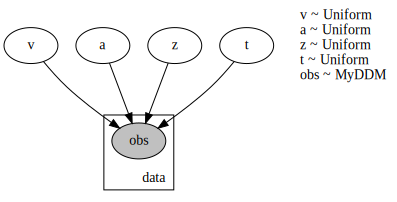

In [78]:
pyro.render_model(basic_ddm_model, model_args = (n_samples, out), 
                  render_distributions = True, 
                  render_params = True)

### Sample / NUTS

In [80]:
# NUTS VERSION
from pyro.infer import MCMC, NUTS
torch_data = torch.tensor(out)

nuts_kernel = NUTS(basic_ddm_model) #, jit_compile = True, ignore_jit_warnings = True) #, step_size = 1, max_tree_depth = 1)
                   #jit_compile = True,
                   #ignore_jit_warnings = True) # step_size = 1, max_tree_depth = 1)
mcmc = MCMC(nuts_kernel, num_samples = 500, warmup_steps = 300, num_chains = 1, initial_params = {'v': torch.tensor(2.0),
                                                                                                    'a': torch.tensor(1.0),
                                                                                                    'z': torch.tensor(0.5),
                                                                                                    't': torch.tensor(1.0)})

# mcmc = MCMC(nuts_kernel, num_samples = 1000, warmup_steps = 1000, num_chains = 2, initial_params = {'v': torch.tensor([2.0, 2.0]),
#                                                                                                     'a': torch.tensor([1.0, 1.0]),
#                                                                                                     'z': torch.tensor([0.5, 0.5]),
#                                                                                                     't': torch.tensor([1.0, 1.0])})
mcmc.run(n_samples, out)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

hmc_samples_new = {}
hmc_samples_new['v'] = np.expand_dims(hmc_samples['v'], axis = (1))
hmc_samples_new['a'] = np.expand_dims(hmc_samples['v'], axis = (1))
hmc_samples_new['z'] = np.expand_dims(hmc_samples['v'], axis = (1))
hmc_samples_new['t'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['g_mu_std'] = np.expand_dims(hmc_samples['g_mu_std'], axis = (1,2))
#hmc_samples_new['subj_mu'] = np.expand_dims(hmc_samples['subj_mu'], axis = 1)

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
Warmup:   1%|          | 9/800 [00:09,  1.52s/it, step size=2.36e-05, acc. prob=0.320]

KeyboardInterrupt: 

In [75]:
# hmc_samples_new['v'] #.shape

(array([ 1.,  2.,  4.,  6., 14., 28., 24., 49., 50., 53., 52., 63., 53.,
        30., 25., 22., 10.,  6.,  6.,  2.]),
 array([0.31940675, 0.33078218, 0.3421576 , 0.35353303, 0.36490846,
        0.37628388, 0.3876593 , 0.39903474, 0.41041017, 0.4217856 ,
        0.43316102, 0.44453645, 0.45591187, 0.4672873 , 0.47866273,
        0.49003816, 0.5014136 , 0.512789  , 0.52416444, 0.53553987,
        0.5469153 ], dtype=float32),
 <BarContainer object of 20 artists>)

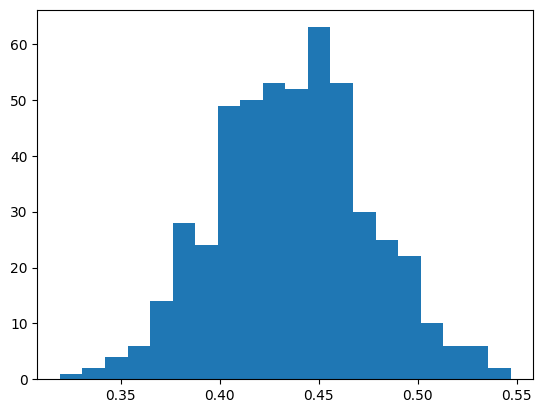

In [66]:
plt.hist(hmc_samples['v'], bins = 20)

### Sample Variational

In [268]:
y_orig = torch.rand(1000, 2)
z = torch.rand(10, 1000, 4)
#torch.hstack([y1, y2, y3, y4]).repeat_interleave(20, dim = 0)
y = y_orig.repeat((10, 1, 1))

In [272]:
y_orig[:10, 0]

tensor([0.2883, 0.6632, 0.5404, 0.2158, 0.5185, 0.8253, 0.8452, 0.3351, 0.2131,
        0.2388])

In [277]:
y_orig.transpose(0, 1)[0, :10]

tensor([0.2883, 0.6632, 0.5404, 0.2158, 0.5185, 0.8253, 0.8452, 0.3351, 0.2131,
        0.2388])

In [273]:
torch.reshape(y_orig, (2, 1000))[0, :10]

tensor([0.2883, 0.3329, 0.6632, 0.4453, 0.5404, 0.6575, 0.2158, 0.0493, 0.5185,
        0.8575])

In [269]:
torch.reshape(y, (2, 1000, 10))

tensor([[[0.2883, 0.3329, 0.6632,  ..., 0.0493, 0.5185, 0.8575],
         [0.8253, 0.4918, 0.8452,  ..., 0.7835, 0.2388, 0.0766],
         [0.0141, 0.5011, 0.8572,  ..., 0.7367, 0.7723, 0.5924],
         ...,
         [0.9713, 0.4909, 0.3023,  ..., 0.7101, 0.9596, 0.3026],
         [0.5621, 0.0474, 0.7780,  ..., 0.3213, 0.6367, 0.7750],
         [0.5675, 0.9182, 0.7646,  ..., 0.6701, 0.1479, 0.9493]],

        [[0.2883, 0.3329, 0.6632,  ..., 0.0493, 0.5185, 0.8575],
         [0.8253, 0.4918, 0.8452,  ..., 0.7835, 0.2388, 0.0766],
         [0.0141, 0.5011, 0.8572,  ..., 0.7367, 0.7723, 0.5924],
         ...,
         [0.9713, 0.4909, 0.3023,  ..., 0.7101, 0.9596, 0.3026],
         [0.5621, 0.0474, 0.7780,  ..., 0.3213, 0.6367, 0.7750],
         [0.5675, 0.9182, 0.7646,  ..., 0.6701, 0.1479, 0.9493]]])

In [254]:
z.shape

torch.Size([10, 1000, 4])

In [255]:
y.shape

torch.Size([10, 1000, 2])

In [264]:
torch.hstack([z, y], dim = 2)

RuntimeError: stack expects each tensor to be equal size, but got [10, 1000, 4] at entry 0 and [10, 1000, 2] at entry 1

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.MyDDM'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')
Guessed max_plate_nesting = 1
Step 0 out of 100, Elbo loss: 2874.221965070399


torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size([])
self.v.dim: 
0
torch.Size([])
torch.Size

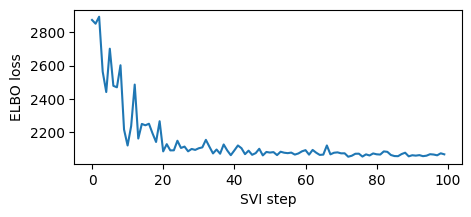

In [54]:
%%time
pyro.clear_param_store()
torch_data = torch.tensor(out)
steps = 100

# These should be reset each training loop.
#auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(basic_ddm_model)
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
#svi = pyro.infer.SVI(basic_hierarchical_model, auto_guide, adam, elbo)

svi = pyro.infer.SVI(basic_ddm_model, auto_guide, adam, elbo)
losses = []
for step in range(steps if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(*(1000, torch_data))
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Step {} out of {}, Elbo loss: {}".format(step, steps, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

#predictive = pyro.infer.Predictive(basic_hierarchical_model, guide = auto_guide, num_samples = 1000)
predictive = pyro.infer.Predictive(basic_ddm_model, guide = auto_guide, num_samples = 1000)
#svi_samples = predictive(20, 1000, torch.tensor(data)) #torch.tensor(data))

In [59]:
predictive = pyro.infer.Predictive(basic_ddm_model, guide = auto_guide, num_samples = 5000)
svi_samples = predictive(1000, torch.tensor(out)) #torch.tensor(data))

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.MyDDM'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


## Define DDM - General Distribution

In [30]:
y1 = torch.rand(2, 1, 1)
y2 = torch.rand(2, 1, 1)
y3 = torch.rand(2, 1, 1)
y4 = torch.rand(2, 1, 1)
repeats = 1000 #value.size()[0]
dat_tmp = torch.rand(1000, 2).repeat((y1.size()[0], 1, 1))
print('dat_tmp shape')
print(dat_tmp.shape)

z = torch.cat([y1, y2, y3, y4], dim = -1)
print(z.shape)
print(z)

w = torch.repeat_interleave(z, repeats, -2)
print(w.shape)

dat_tmp = torch.cat([w, dat_tmp], dim = -1)



dat_tmp shape
torch.Size([2, 1000, 2])
torch.Size([2, 1, 4])
tensor([[[0.3998, 0.5761, 0.0845, 0.5831]],

        [[0.3241, 0.3163, 0.0314, 0.0995]]])
torch.Size([2, 1000, 4])


In [37]:
tmp = torch.rand(1000, 2).repeat(0, 1, 1)

SyntaxError: invalid syntax (<ipython-input-40-5adcc51a1273>, line 1)

In [31]:
dat_tmp.shape

torch.Size([2, 1000, 6])

In [18]:
y1 = torch.rand(1)
y2 = torch.rand(1)
y3 = torch.rand(1)
y4 = torch.rand(1)

print(y1.size())

tmp = torch.cat([y1, y2, y3, y4], dim = -1)
print(tmp.shape)
print(tmp)

tmp2 = tmp.tile((100, 1))
print(tmp2.shape)
print(tmp2[0, :])





torch.Size([1])
torch.Size([4])
tensor([0.8631, 0.9195, 0.2201, 0.0326])
torch.Size([100, 4])
tensor([0.8631, 0.9195, 0.2201, 0.0326])


In [33]:
import math
from numbers import Real
from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

network_config = pickle.load(open('hddm_torch_models/torch_models/eba53550128911ec9fef3cecef056d26_angle_torch__network_config.pickle',
                                  'rb'))
network = lanfactory.trainers.torch_mlp.TorchMLP(network_config = network_config,
                                                 input_shape = 6)

network.load_state_dict(torch.load('hddm_torch_models/torch_models/d27193a4153011ecb76ca0423f39a3e6_ddm_torch_state_dict.pt'))
network.eval()


class MyDDMb(dist.TorchDistribution):
#     arg_constraints = {'loc': constraints.interval(-1, 1),
#                        'scale': constraints.interval(0.0001, 10)
#                       }
    def __init__(self, v, a, z, t):
        self.net = network
        self.net_rep_n = 1
        # print('v shape')
        # print(v.shape)
        self.v = torch.unsqueeze(v, dim = -1)
        self.a = torch.unsqueeze(a, dim = -1)
        self.z = torch.unsqueeze(z, dim = -1)
        self.t = torch.unsqueeze(t, dim = -1)
        #print('v shape')
        #print(self.v.shape)
        if isinstance(v, Number): # and isinstance(a, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.v.size()
            if not self.v.size() == torch.Size([]):
                self.net_rep_n = batch_shape[0]
                
        super().__init__(batch_shape = batch_shape, event_shape = torch.Size((2,))) # event_shape = (1,))
        
    def sample(self):
        theta = torch.vstack([self.v, self.a, self.z, self.t]).T
        return sim_wrap(theta = theta, model = 'ddm')
    
    def log_prob(self, value):
        #print('value size: ')
        #print(value.size())
        # New
        tmp_params = torch.stack([self.v, self.a, self.z, self.t], dim = -1)
        tmp_params2 = tmp_params.repeat_interleave(value.size()[0], -2)
        #print('self.v.dim: ')
        #print(self.v.dim())
        if self.v.dim() == 3:
            dat_tmp = value.repeat((self.v.size()[0], self.v.size()[1], 1, 1))
        else: 
            dat_tmp = value
            
        #print('dat_tmp size')
        #print(dat_tmp.size())
            
        #tmp_params = torch.cat([self.v, self.a, self.z, self.t])
        #print('tmp_params2 size')
        #print(tmp_params2.shape)
        #tmp_params2 = tmp_params.repeat_interleave(value.size()[0], -2)
        net_in = torch.cat([tmp_params2, dat_tmp], dim = -1)
        
        # Old
        #net_in = torch.hstack([torch.hstack([self.v, self.a, self.z, self.t]).tile(value.size()[0], 1), value])
        logp = torch.clip(self.net(net_in), min = -16.11)
        print('logp shape')
        print(logp.shape)
        
        logp_squeezed = torch.squeeze(logp, dim = -1)
        print('logp squeezed shape')
        print(logp_squeezed.shape)
        if self.v.dim() == 3:
            logp_squeezed = logp_squeezed.unsqueeze(1)
        return logp_squeezed
        #return torch.squeeze(torch.clip(self.net(net_in), min = -16.11))
    
    
    
# repeats = 1000 #value.size()[0]
# dat_tmp = torch.rand(1000, 2).repeat((y1.size()[0], 1, 1))
# print('dat_tmp shape')
# print(dat_tmp.shape)

# z = torch.cat([y1, y2, y3, y4], dim = -1)
# print(z.shape)
# print(z)

# w = torch.repeat_interleave(z, repeats, -2)
# print(w.shape)

# dat_tmp = torch.cat([w, dat_tmp], dim = -1)

tanh
tanh
linear


In [38]:
#torch.stack([self.v, self.a, self.z, self.t]
            
y = torch.rand(10, 1, 20)

torch.stack([y, y, y, y], dim = -1).shape

torch.Size([10, 1, 20, 4])

In [41]:
custom_torch_net(torch.rand(10, 500, 20, 6)).shape

torch.Size([10, 500, 20, 1])

In [114]:
class MyDDMc(dist.TorchDistribution):
#     arg_constraints = {'loc': constraints.interval(-1, 1),
#                        'scale': constraints.interval(0.0001, 10)
#                       }
    def __init__(self, v, a, z, t):
        self.net = network
        self.net_rep_n = 1
        # print('v shape')
        # print(v.shape)
        self.v = v #torch.unsqueeze(v, dim = -1)
        self.a = a #torch.unsqueeze(a, dim = -1)
        self.z = z #torch.unsqueeze(z, dim = -1)
        self.t = t #torch.unsqueeze(t, dim = -1)
        #print('v shape')
        #print(self.v.shape)
        if isinstance(v, Number): # and isinstance(a, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.v.size()
            if not self.v.size() == torch.Size([]):
                self.net_rep_n = batch_shape[0]
                
        super().__init__(batch_shape = batch_shape, event_shape = torch.Size((2,))) # event_shape = (1,))
        
    def sample(self):
        theta = torch.vstack([self.v, self.a, self.z, self.t]).T
        return sim_wrap(theta = theta, model = 'ddm')
    
    def log_prob(self, value):
        #print('value size: ')
        #print(value.size())
        #print('self.v.dim: ')
        #print(self.v.dim())
        print('batch shape: ')
        print(self.batch_shape)
        
        # New
        tmp_params = torch.stack([self.v, self.a, self.z, self.t], dim = -1)
        
        if self.v.dim() == 0:
            tmp_params = tmp_params.unsqueeze(0)
        
        #print('tmp params shape: ')
        #print(tmp_params.size())
        tmp_params2 = tmp_params.repeat_interleave(value.size()[0], -2)
        
        if self.v.dim() == 2:
            dat_tmp = value.repeat((self.v.size()[0], 1, 1))
        else: 
            dat_tmp = value
            
        #print('dat_tmp size')
        #print(dat_tmp.size())
            
        #tmp_params = torch.cat([self.v, self.a, self.z, self.t])
        #print('tmp_params2 size')
        #print(tmp_params2.shape)
        #tmp_params2 = tmp_params.repeat_interleave(value.size()[0], -2)
        net_in = torch.cat([tmp_params2, dat_tmp], dim = -1)
        
        # Old
        #net_in = torch.hstack([torch.hstack([self.v, self.a, self.z, self.t]).tile(value.size()[0], 1), value])
        logp = torch.clip(self.net(net_in), min = -16.11)
        #print('logp shape')
        #print(logp.shape)
        
        logp_squeezed = torch.squeeze(logp, dim = -1)
        #print('logp squeezed shape')
        #print(logp_squeezed.shape)
        # if self.v.dim() == 2:
        #     logp_squeezed = logp_squeezed.unsqueeze(1)
        return logp_squeezed
        #return torch.squeeze(torch.clip(self.net(net_in), min = -16.11))
    
    
    
# repeats = 1000 #value.size()[0]
# dat_tmp = torch.rand(1000, 2).repeat((y1.size()[0], 1, 1))
# print('dat_tmp shape')
# print(dat_tmp.shape)

# z = torch.cat([y1, y2, y3, y4], dim = -1)
# print(z.shape)
# print(z)

# w = torch.repeat_interleave(z, repeats, -2)
# print(w.shape)

# dat_tmp = torch.cat([w, dat_tmp], dim = -1)

In [52]:
y = MyDDMbatch(v = torch.tensor([0]), 
               a = torch.tensor([1]),
               z = torch.tensor([0.5]),
               t = torch.tensor([1.0]))

passing v not a number
batch shape: 
torch.Size([1])
self.net_rep_n
1


In [41]:
torch.rand(1,1,1).expand((1, 1, 10, 1)).shape

torch.Size([1, 1, 10, 1])

In [42]:
torch.Size([1, 1])

torch.Size([1, 1])

In [78]:
y = torch.rand(1)

torch.stack([y, y, y, y], dim = -1).shape


torch.Size([1, 4])

In [79]:
z = torch.rand(2, 1, 1)

test = torch.stack([z, z, z, z], dim = -1)

In [81]:
test.repeat(100, -2)

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [88]:
test.repeat_interleave(100, -2).shape

torch.Size([2, 1, 100, 4])

In [96]:
y = torch.rand(1000, 2)

In [100]:
z = y.repeat(2, 1, 1, 1)

In [102]:
torch.cat([z, z], dim = -1).shape

torch.Size([2, 1, 1000, 4])

In [86]:
help(torch.Tensor.repeat_interleave)

Help on method_descriptor:

repeat_interleave(...)
    repeat_interleave(repeats, dim=None, *, output_size=None) -> Tensor
    
    See :func:`torch.repeat_interleave`.



In [71]:
y.squeeze().shape

torch.Size([4, 4])

### Simulate data

In [116]:
base_dim = 1
n_samples = 1000
v = torch.zeros(base_dim) + 0.5
a = torch.zeros(base_dim) + 1.5
z = torch.zeros(base_dim) + 0.5
t = torch.zeros(base_dim) + 0.5
theta = torch.vstack([v, a, z, t]).T
theta = theta.tile((n_samples, 1))
out = sim_wrap(theta = theta)
theta = torch.hstack([theta, out])

In [117]:
theta

tensor([[ 0.5000,  1.5000,  0.5000,  0.5000,  1.1900,  1.0000],
        [ 0.5000,  1.5000,  0.5000,  0.5000,  1.9450,  1.0000],
        [ 0.5000,  1.5000,  0.5000,  0.5000,  2.9990,  1.0000],
        ...,
        [ 0.5000,  1.5000,  0.5000,  0.5000,  1.6340,  1.0000],
        [ 0.5000,  1.5000,  0.5000,  0.5000,  1.3590,  1.0000],
        [ 0.5000,  1.5000,  0.5000,  0.5000,  2.3730, -1.0000]])

### Define DDM Model

In [118]:
def basic_ddm_model(num_trials, data):
    v = pyro.sample("v", dist.Uniform(-3, 3))
    a = pyro.sample("a", dist.Uniform(0.3, 2.5))
    z = pyro.sample("z", dist.Uniform(0.1, 0.9))
    t = pyro.sample("t", dist.Uniform(0.0, 2.0))
    
    with pyro.plate("data", num_trials) as data_plate:
        return pyro.sample("obs", MyDDMc(v, a, z, t), obs = data)

In [119]:
auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(basic_ddm_model)

batch shape: 
torch.Size([])
batch shape: 
torch.Size([])


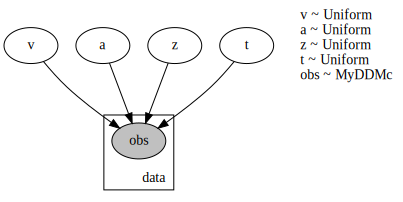

In [120]:
pyro.render_model(basic_ddm_model, model_args = (1000, out), 
                  render_distributions = True, 
                  render_params = True)

### Sample / NUTS

In [119]:
# NUTS VERSION
from pyro.infer import MCMC, NUTS
torch_data = torch.tensor(out)

nuts_kernel = NUTS(basic_ddm_model, step_size = 1, max_tree_depth = 1)
mcmc = MCMC(nuts_kernel, num_samples = 2, warmup_steps = 1, num_chains = 1, initial_params = {'v': torch.tensor(2.0),
                                                                                              'a': torch.tensor(1.0),
                                                                                              'z': torch.tensor(0.5),
                                                                                              't': torch.tensor(1.0)})
mcmc.run(1000, out)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

hmc_samples_new = {}
hmc_samples_new['v'] = np.expand_dims(hmc_samples['v'], axis = (1))
hmc_samples_new['a'] = np.expand_dims(hmc_samples['v'], axis = (1))
hmc_samples_new['z'] = np.expand_dims(hmc_samples['v'], axis = (1))
hmc_samples_new['t'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['g_mu_std'] = np.expand_dims(hmc_samples['g_mu_std'], axis = (1,2))
#hmc_samples_new['subj_mu'] = np.expand_dims(hmc_samples['subj_mu'], axis = 1)

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
Sample: 100%|██████████| 3/3 [00:00, 26.03it/s, step size=6.25e-02, acc. prob=0.000]

v shape
torch.Size([1])
v shape
torch.Size([1])
v shape
torch.Size([1])
value size: 
torch.Size([1000, 2])
dat_tmp size
torch.Size([1000, 2])
tmp_params2 size
torch.Size([1000, 4])
v shape
torch.Size([1])
value size: 
torch.Size([1000, 2])
dat_tmp size
torch.Size([1000, 2])
tmp_params2 size
torch.Size([1000, 4])
v shape
torch.Size([1])
value size: 
torch.Size([1000, 2])
dat_tmp size
torch.Size([1000, 2])
tmp_params2 size
torch.Size([1000, 4])
v shape
torch.Size([1])
value size: 
torch.Size([1000, 2])
dat_tmp size
torch.Size([1000, 2])
tmp_params2 size
torch.Size([1000, 4])
v shape
torch.Size([1])
value size: 
torch.Size([1000, 2])
dat_tmp size
torch.Size([1000, 2])
tmp_params2 size
torch.Size([1000, 4])
v shape
torch.Size([1])
value size: 
torch.Size([1000, 2])
dat_tmp size
torch.Size([1000, 2])
tmp_params2 size
torch.Size([1000, 4])
v shape
torch.Size([1])
value size: 
torch.Size([1000, 2])
dat_tmp size
torch.Size([1000, 2])
tmp_params2 size
torch.Size([1000, 4])
v shape
torch.Size([1

### Sample Variational

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.MyDDMc'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')
Guessed max_plate_nesting = 2
Step 0 out of 100, Elbo loss: 2774.804013361214


batch shape: 
torch.Size([])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch.Size([10, 1])
batch shape: 
torch

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


TypeError: basic_ddm_model() takes 2 positional arguments but 3 were given

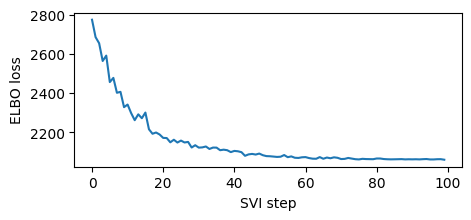

In [121]:
%%time
pyro.clear_param_store()
torch_data = torch.tensor(out)
steps = 100

# These should be reset each training loop.
#auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(basic_ddm_model)
adam = pyro.optim.Adam({"lr": 0.02})
#elbo = pyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
elbo = pyro.infer.Trace_ELBO(num_particles = 10, vectorize_particles = True)
#elbo = pyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
#svi = pyro.infer.SVI(basic_hierarchical_model, auto_guide, adam, elbo)

svi = pyro.infer.SVI(basic_ddm_model, auto_guide, adam, elbo)
losses = []
for step in range(steps if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(*(1000, torch_data))
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Step {} out of {}, Elbo loss: {}".format(step, steps, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

#predictive = pyro.infer.Predictive(basic_hierarchical_model, guide = auto_guide, num_samples = 1000)
predictive = pyro.infer.Predictive(basic_ddm_model, guide = auto_guide, num_samples = 1000)
svi_samples = predictive(20, 1000, torch.tensor(data)) #torch.tensor(data))

In [90]:
predictive = pyro.infer.Predictive(basic_ddm_model, guide = auto_guide, num_samples = 5000)
svi_samples = predictive(1000, torch.tensor(out)) #torch.tensor(data))

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(array([   8.,   48.,  256.,  690., 1248., 1345.,  921.,  384.,   82.,
          18.]),
 array([0.38529884, 0.40661557, 0.42793229, 0.44924901, 0.47056574,
        0.49188246, 0.51319918, 0.5345159 , 0.55583263, 0.57714935,
        0.59846607]),
 <BarContainer object of 10 artists>)

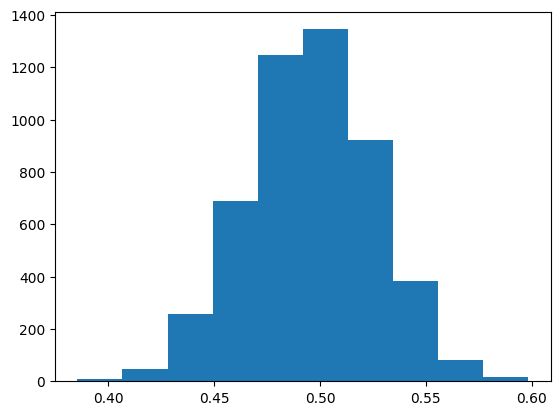

In [91]:
plt.hist(svi_samples['v'].squeeze().numpy())

In [178]:
predictive = pyro.infer.Predictive(basic_ddm_model, guide = auto_guide, num_samples = 5000)
svi_samples = predictive(1000, torch.tensor(out)) #torch.tensor(data))

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(array([  18.,   91.,  296.,  806., 1305., 1245.,  805.,  327.,   93.,
          14.]),
 array([0.42724905, 0.44762537, 0.46800168, 0.488378  , 0.50875432,
        0.52913064, 0.54950696, 0.56988327, 0.59025959, 0.61063591,
        0.63101223]),
 <BarContainer object of 10 artists>)

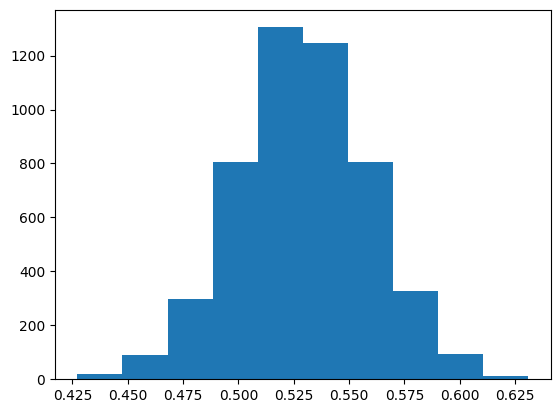

In [180]:
plt.hist(svi_samples['v'].squeeze().numpy())

## Define DDM - Hierarchical

In [220]:
base_dim = 1
n_samples = 500
v = torch.zeros(base_dim) + 0.5
a = torch.zeros(base_dim) + 1.5
z = torch.zeros(base_dim) + 0.5
t = torch.zeros(base_dim) + 0.5
theta = torch.vstack([v, a, z, t]).T
theta = theta.tile((n_samples, 1))
out = sim_wrap(theta = theta)
theta = torch.hstack([theta, out])

In [221]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'hddm_include': ['z'],
 'nchoices': 2}

In [10]:
model_config = ssms.config.model_config["ddm"]
base_dim = 1
n_subjects = 20
n_samples_by_subject = 500
buffer_coefficient = 0.5

param_dict = {}
data_list = []
for param in model_config['params']:
    param_idx = model_config['params'].index(param)
    print('param')
    print(param)
    min_ = model_config['param_bounds'][0][param_idx]
    max_ = model_config['param_bounds'][1][param_idx]
    range_ = max_ - min_
    mean_ = (max_ + min_) / 2
    min_adj = mean_ - (0.5 * buffer_coefficient) * range_
    print(min_adj)
    max_adj = mean_ + (0.5 * buffer_coefficient) * range_
    print(max_adj)
    
    param_mu_mu = np.random.uniform(low = min_adj, high = max_adj) # potentially fix
    param_mu_std = np.random.uniform(low = 0.05, high = 0.1) # potentially fix
    param_mu = scipy.stats.norm.rvs(loc = param_mu_mu, scale = param_mu_std)
    param_std = scipy.stats.halfnorm.rvs(loc = 0, scale = 0.1) # potentially fix
    # param_std_std = scipy.stats.halfnorm(loc = 0, scale = 0.25) # potentially fix
    
    params_subj = np.random.normal(loc = param_mu, 
                                   scale = param_std, 
                                   size = n_subjects)
    
    param_dict[param + '_mu'] = param_mu.astype(np.float32)
    param_dict[param + '_std'] =  param_std.astype(np.float32)
    param_dict[param + '_subj'] = params_subj.astype(np.float32)
    
print(param_dict)
    
    
for i in range(n_subjects):
    v = torch.zeros(base_dim) + param_dict['v_subj'][i]
    a = torch.zeros(base_dim) + param_dict['a_subj'][i]
    z = torch.zeros(base_dim) + param_dict['z_subj'][i]
    t = torch.zeros(base_dim) + param_dict['t_subj'][i]
    
    theta = torch.vstack([v, a, z, t]).T
    theta = theta.tile((n_samples_by_subject, 1))
    out = sim_wrap(theta = theta)
    # theta = torch.hstack([theta, out])
    data_list.append(out)
    
#data = torch.stack(data_list).permute(2, 1, 0)
#data = torch.stack(data_list).permute(1, 2, 0)
#data = torch.stack(data_list).permute(2, 0, 1)
data = torch.stack(data_list).permute(1, 0, 2)

#data = torch.stack(data_list).unsqueeze(1).permute(2, 0, 3, 1)

param
v
-1.5
1.5
param
a
0.8499999999999999
1.95
param
z
0.3
0.7
param
t
0.5
1.5
{'v_mu': -1.5526872, 'v_std': 0.0012882757, 'v_subj': array([-1.5531745, -1.5533069, -1.5546418, -1.5533195, -1.5529972,
       -1.5535219, -1.551868 , -1.5504453, -1.5523049, -1.5517757,
       -1.5503389, -1.5521321, -1.5506997, -1.5538476, -1.5528637,
       -1.5510155, -1.5518172, -1.5526459, -1.5515043, -1.5521969],
      dtype=float32), 'a_mu': 1.9485394, 'a_std': 0.035523947, 'a_subj': array([1.955956 , 1.9602058, 1.9308405, 1.8742312, 1.9456055, 2.035757 ,
       1.8536155, 1.9160961, 1.9404643, 1.9581065, 1.9886978, 1.9855695,
       1.9948559, 1.9978963, 1.9252195, 1.9465408, 1.9307809, 1.9640427,
       1.935189 , 1.9157486], dtype=float32), 'z_mu': 0.43957964, 'z_std': 0.08247703, 'z_subj': array([0.33971325, 0.39806026, 0.38168773, 0.2767476 , 0.22054273,
       0.43482217, 0.38545933, 0.38500404, 0.5030332 , 0.36543238,
       0.5792659 , 0.29958847, 0.20919076, 0.4209274 , 0.4723584 ,
      

In [16]:
param

torch.Size([500, 10, 2])

In [36]:
param_dict['v_mu']

(-1.1427435190319604,)

In [119]:
# def basic_ddm_model(num_trials, data):
#     v = pyro.sample("v", dist.Uniform(-3, 3))
#     a = pyro.sample("a", dist.Uniform(0.3, 2.5))
#     z = pyro.sample("z", dist.Uniform(0.1, 0.9))
#     t = pyro.sample("t", dist.Uniform(0.0, 2.0))
    
#     with pyro.plate("subject
#     with pyro.plate("data", num_trials) as data_plate:
#         return pyro.sample("obs", MyDDMc(v, a, z, t), obs = data)

In [214]:
def broadcast_shape(*shapes, **kwargs):
    """
    Similar to ``np.broadcast()`` but for shapes.
    Equivalent to ``np.broadcast(*map(np.empty, shapes)).shape``.

    :param tuple shapes: shapes of tensors.
    :param bool strict: whether to use extend-but-not-resize broadcasting.
    :returns: broadcasted shape
    :rtype: tuple
    :raises: ValueError
    """
    strict = kwargs.pop("strict", False)
    reversed_shape = []
    for shape in shapes:
        for i, size in enumerate(reversed(shape)):
            if i >= len(reversed_shape):
                reversed_shape.append(size)
            elif reversed_shape[i] == 1 and not strict:
                reversed_shape[i] = size
            elif reversed_shape[i] != size and (size != 1 or strict):
                raise ValueError(
                    "shape mismatch: objects cannot be broadcast to a single shape: {}".format(
                        " vs ".join(map(str, shapes))
                    )
                )
    return tuple(reversed(reversed_shape))

In [218]:
broadcast_shape((10, 500), torch.Size([2, 10, 500])) #, strict = False)
    
#(500, 10) vs torch.Size([500, 2]

(2, 10, 500)

In [45]:
y = torch.rand(100, 10, 1)

In [99]:
network(torch.tensor([60.0, 1.0, 0.5, 0.5, 1.5, 1.0]))

tensor([[2.0197]])

In [46]:
y.repeat(10, 1, 1, 1).shape

torch.Size([10, 100, 10, 1])

### Define DDM-hierarchical distribution

In [73]:
y = torch.rand(10, 1, 20)
tmp_params = torch.stack([y, y, y, y], dim = -1).tile(1, 500, 1, 1)
tmp_params.shape

torch.Size([10, 500, 20, 4])

In [11]:
import math
from numbers import Real
from numbers import Number

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

# network_config = pickle.load(open('hddm_torch_models/torch_models/eba53550128911ec9fef3cecef056d26_angle_torch__network_config.pickle',
#                                   'rb'))
# network = lanfactory.trainers.torch_mlp.TorchMLP(network_config = network_config,
#                                                  input_shape = 6)

# network.load_state_dict(torch.load('hddm_torch_models/torch_models/d27193a4153011ecb76ca0423f39a3e6_ddm_torch_state_dict.pt'))
# network.eval()
network = custom_torch_net

class MyDDMh(dist.TorchDistribution):
#     arg_constraints = {'loc': constraints.interval(-1, 1),
#                        'scale': constraints.interval(0.0001, 10)
#                       }
    def __init__(self, v, a, z, t):
        self.net = network
        self.n_samples = n_samples_by_subject
        self.boundaries = model_config['param_bounds']
        self.out_of_bounds_val = -66.1
        self.v = v
        self.a = a
        self.z = z
        self.t = t
        
        if isinstance(v, Number): # and isinstance(a, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.v.size()
            
        super().__init__(batch_shape = batch_shape, event_shape = torch.Size((2,))) #torch.Size((2,))) # event_shape = (1,))
        
    def sample(self):
        theta = torch.vstack([self.v, self.a, self.z, self.t]).T
        return sim_wrap(theta = theta, model = 'ddm')
    
    def log_prob(self, value):
#         print('value shape')
#         print(value.shape)
        
#         print('v shape')
#         print(self.v.shape)
        
        if self.v.dim() == 3:
            dat_tmp = value.repeat((self.v.size()[0], 1, 1, 1))
            # print('dat_tmp shape')
            # print(dat_tmp.shape)
            tmp_params = torch.stack([self.v, self.a, self.z, self.t], dim = -1).tile((1, self.n_samples, 1, 1))
            
            # print('tmp_params shape')
            # print(tmp_params.shape)
            
            net_in = torch.cat([tmp_params, dat_tmp], dim = -1)
            logp = torch.clip(self.net(net_in), min = -16.11)
            logp_squeezed = torch.squeeze(logp, dim = -1)
            
            # v constraint
            logp_squeezed = torch.where(net_in[:, :, :, 0] < torch.tensor(3.), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            logp_squeezed = torch.where(net_in[:, :, :, 0] > torch.tensor(-3.), logp_squeezed, torch.tensor(self.out_of_bounds_val))

            # a constraint
            logp_squeezed = torch.where(net_in[:, :, :, 1] < torch.tensor(2.5), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            logp_squeezed = torch.where(net_in[:, :, :, 1] > torch.tensor(0.3), logp_squeezed, torch.tensor(self.out_of_bounds_val))

            # z constraint
            logp_squeezed = torch.where(net_in[:, :, :, 2] < torch.tensor(0.9), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            logp_squeezed = torch.where(net_in[:, :, :, 2] > torch.tensor(0.1), logp_squeezed, torch.tensor(self.out_of_bounds_val))

            # t constraint
            logp_squeezed = torch.where(net_in[:, :, :, 3] < torch.tensor(2.0), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            logp_squeezed = torch.where(net_in[:, :, :, 3] > torch.tensor(0.0), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            
            logp_squeezed = logp_squeezed #.unsqueeze(1)
        else: # single particle:
            tmp_params = torch.stack([self.v, self.a, self.z, self.t], dim = -1).tile((self.n_samples, 1, 1))

            net_in = torch.cat([tmp_params, value], dim = -1)
            logp = torch.clip(self.net(net_in), min = -16.11)
            logp_squeezed = torch.squeeze(logp, dim = -1)

            # v constraint
            logp_squeezed = torch.where(net_in[:, :, 0] < torch.tensor(3.), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            logp_squeezed = torch.where(net_in[:, :, 0] > torch.tensor(-3.), logp_squeezed, torch.tensor(self.out_of_bounds_val))

            # a constraint
            logp_squeezed = torch.where(net_in[:, :, 1] < torch.tensor(2.5), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            logp_squeezed = torch.where(net_in[:, :, 1] > torch.tensor(0.3), logp_squeezed, torch.tensor(self.out_of_bounds_val))

            # z constraint
            logp_squeezed = torch.where(net_in[:, :, 2] < torch.tensor(0.9), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            logp_squeezed = torch.where(net_in[:, :, 2] > torch.tensor(0.1), logp_squeezed, torch.tensor(self.out_of_bounds_val))

            # t constraint
            logp_squeezed = torch.where(net_in[:, :, 3] < torch.tensor(2.0), logp_squeezed, torch.tensor(self.out_of_bounds_val))
            logp_squeezed = torch.where(net_in[:, :, 3] > torch.tensor(0.0), logp_squeezed, torch.tensor(self.out_of_bounds_val))

            #logp_squeezed = logp.reshape((self.n_samples, -1))
            #logp_squeezed = torch.squeeze(logp, dim = -1)
            
#         print('logp out shape')
#         print(logp_squeezed.shape)
        
        return logp_squeezed
       
#####

# tmp_params = torch.stack([self.v, self.a, self.z, self.t], dim = -1)
#         tmp_params2 = tmp_params.repeat_interleave(value.size()[0], -2)
#         #print('self.v.dim: ')
#         #print(self.v.dim())
#         if self.v.dim() == 3:
#             dat_tmp = value.repeat((self.v.size()[0], self.v.size()[1], 1, 1))
#         else: 
#             dat_tmp = value
            
#         #print('dat_tmp size')
#         #print(dat_tmp.size())
            
#         #tmp_params = torch.cat([self.v, self.a, self.z, self.t])
#         #print('tmp_params2 size')
#         #print(tmp_params2.shape)
#         #tmp_params2 = tmp_params.repeat_interleave(value.size()[0], -2)
#         net_in = torch.cat([tmp_params2, dat_tmp], dim = -1)
        
#         # Old
#         #net_in = torch.hstack([torch.hstack([self.v, self.a, self.z, self.t]).tile(value.size()[0], 1), value])
#         logp = torch.clip(self.net(net_in), min = -16.11)
#         print('logp shape')
#         print(logp.shape)
        
#         logp_squeezed = torch.squeeze(logp, dim = -1)
#         print('logp squeezed shape')
#         print(logp_squeezed.shape)
#         if self.v.dim() == 3:
#             logp_squeezed = logp_squeezed.unsqueeze(1)
#         return logp_squeezed
#         #return torch.squeeze(torch.clip(self.net(net_in), min = -16.11))
    
    

### Define DDM Model

In [12]:
def hierarchical_ddm_model(num_subjects, num_trials, data):
    #v_mu_mu = pyro.sample("v_mu_mu", dist.Uniform(-3, 3))
    v_mu_mu = pyro.sample("v_mu_mu", dist.Normal(0, 0.5))
    v_mu_std = pyro.sample("v_mu_std", dist.HalfNormal(100.))
    
    #a_mu_mu = pyro.sample("a_mu_mu", dist.Uniform(0.3, 2.5))
    a_mu_std = pyro.sample("a_mu_std", dist.HalfNormal(100.))
    a_mu_mu = pyro.sample("a_mu_mu", dist.Normal(1.5, 0.5))

    #z_mu_mu = pyro.sample("z_mu_mu", dist.Uniform(0.1, 0.9))
    z_mu_std = pyro.sample("z_mu_std", dist.HalfNormal(100.))
    z_mu_mu = pyro.sample("z_mu_mu", dist.Normal(0.5, 0.1))
    
    #t_mu_mu = pyro.sample("t_mu_mu", dist.Uniform(0.0, 2.0))
    t_mu_std = pyro.sample("t_mu_std", dist.HalfNormal(100.))
    t_mu_mu = pyro.sample("t_mu_mu", dist.Normal(1.0, 0.5))

    with pyro.plate("subjects", num_subjects) as subjects_plate:
        v_subj = pyro.sample("v_subj", dist.Normal(v_mu_mu, v_mu_std))
        a_subj = pyro.sample("a_subj", dist.Normal(a_mu_mu, a_mu_std))
        z_subj = pyro.sample("z_subj", dist.Normal(z_mu_mu, z_mu_std))
        t_subj = pyro.sample("t_subj", dist.Normal(t_mu_mu, t_mu_std))
        with pyro.plate("data", num_trials) as data_plate:
            return pyro.sample("obs", 
                               MyDDMh(v_subj, a_subj, z_subj, t_subj), 
                               obs = data)

In [196]:
def hierarchical_noncentered_ddm_model(num_subjects, num_trials, data):
    v_mu_mu = pyro.sample("v_mu_mu", dist.Uniform(-3, 3))
    v_mu_std = pyro.sample("v_mu_std", dist.HalfNormal(1.))
    
    a_mu_mu = pyro.sample("a_mu_mu", dist.Uniform(0.3, 2.5))
    a_mu_std = pyro.sample("a_mu_std", dist.HalfNormal(1.))
    
    z_mu_mu = pyro.sample("z_mu_mu", dist.Uniform(0.1, 0.9))
    z_mu_std = pyro.sample("z_mu_std", dist.HalfNormal(1.))
    
    t_mu_mu = pyro.sample("t_mu_mu", dist.Uniform(0.0, 2.0))
    t_mu_std = pyro.sample("t_mu_std", dist.HalfNormal(1.))
    
    with pyro.plate("subjects", num_subjects) as subjects_plate:
        v_subj_z = pyro.sample("v_subj_z", 
                               dist.Normal(torch.tensor(0.0), torch.tensor(1.0)))
        a_subj_z = pyro.sample("a_subj_z", 
                               dist.Normal(torch.tensor(0.0), torch.tensor(1.0)))
        z_subj_z = pyro.sample("z_subj_z", 
                               dist.Normal(torch.tensor(0.0), torch.tensor(1.0)))
        t_subj_z = pyro.sample("t_subj_z", 
                               dist.Normal(torch.tensor(0.0), torch.tensor(1.0)))
        
        v_subj = pyro.deterministic("v_subj", v_mu_mu + (v_subj_z * v_mu_std))
        a_subj = pyro.deterministic("a_subj", a_mu_mu + (a_subj_z * a_mu_std))
        z_subj = pyro.deterministic("z_subj", z_mu_mu + (z_subj_z * z_mu_std))
        t_subj = pyro.deterministic("t_subj", t_mu_mu + (t_subj_z * t_mu_std))

        with pyro.plate("data", num_trials) as data_plate:
            return pyro.sample("obs", 
                               MyDDMh(v_subj, a_subj, z_subj, t_subj), 
                               obs = data)

### Define Guide

In [25]:
def hierarchical_ddm_guide(num_subjects, num_trials, data):
    # Initialize the parameters:
    # ----------------
    # Global mus
    v_mu_mu_loc = pyro.param('v_mu_mu_loc', lambda:torch.tensor(0.),
                             constraint = constraints.interval(-3, 3))
    v_mu_mu_scale = pyro.param('v_mu_mu_scale', lambda:torch.tensor(0.02),
                               constraint = constraints.positive)
    
    a_mu_mu_loc = pyro.param('a_mu_mu_loc', lambda:torch.tensor(1.),
                             constraint = constraints.interval(0.3, 2.5))
    a_mu_mu_scale = pyro.param('a_mu_mu_scale', lambda:torch.tensor(0.02),
                               constraint = constraints.positive)
    
    z_mu_mu_loc = pyro.param('z_mu_mu_loc', lambda:torch.tensor(0.5),
                             constraint = constraints.interval(0.1, 0.9))
    z_mu_mu_scale = pyro.param('z_mu_mu_scale', lambda:torch.tensor(0.02),
                               constraint = constraints.positive)
    
    t_mu_mu_loc = pyro.param('t_mu_mu_loc', lambda:torch.tensor(0.5),
                             constraint = constraints.interval(0.0, 2.0))
    t_mu_mu_scale = pyro.param('t_mu_mu_scale', lambda:torch.tensor(0.02),
                               constraint = constraints.positive)
    
    # Global stds
    v_mu_std_scale = pyro.param('v_mu_std_scale', lambda:torch.tensor(1/100),
                                constraint = constraints.positive)
    v_mu_std_concentration = pyro.param('v_mu_std_concentration', lambda:torch.tensor(10.),
                                        constraint = constraints.positive)
    
    a_mu_std_scale = pyro.param('a_mu_std_scale', lambda:torch.tensor(1/100),
                                constraint = constraints.positive)
    a_mu_std_concentration = pyro.param('a_mu_std_concentration', lambda:torch.tensor(10.),
                                        constraint = constraints.positive)
    
    z_mu_std_scale = pyro.param('z_mu_std_scale', lambda:torch.tensor(1/100),
                                constraint = constraints.positive)
    z_mu_std_concentration = pyro.param('z_mu_std_concentration', lambda:torch.tensor(10.),
                                        constraint = constraints.positive)
    
    t_mu_std_scale = pyro.param('t_mu_std_scale', lambda:torch.tensor(1/100),
                                constraint = constraints.positive)
    t_mu_std_concentration = pyro.param('t_mu_std_concentration', lambda:torch.tensor(10.),
                                        constraint = constraints.positive)
    
    # 
    
    # subj_mus
    #
    v_subj_mu_loc = pyro.param('v_subj_mus', 
                                  lambda:torch.rand(num_subjects) - torch.tensor(0.5),
                                  constraint = constraints.interval(-3, 3))
    
    v_subj_mu_scale = pyro.param('v_subj_scales', 
                                    lambda:torch.ones(num_subjects) + \
                                    (torch.rand(num_subjects) - torch.tensor(0.5)) / 5,
                                    constraint = constraints.positive)

    
    a_subj_mu_loc = pyro.param('a_subj_mus', 
                                  lambda:(torch.rand(num_subjects) - 0.5) + 1.5,
                                  constraint = constraints.interval(0.3, 2.5))
    a_subj_mu_scale = pyro.param('a_subj_scales', 
                                    lambda:torch.ones(num_subjects) + \
                                    (torch.rand(num_subjects) - 0.5) / 5,
                                    constraint = constraints.positive)
    
    z_subj_mu_loc = pyro.param('z_subj_mus', 
                                  lambda:(torch.rand(num_subjects) / 5) + 0.3,
                                  constraint = constraints.interval(0.1, 0.9))
    z_subj_mu_scale = pyro.param('z_subj_scales', 
                                    lambda:torch.ones(num_subjects) / 50,
                                    constraint = constraints.positive)
    
    t_subj_mu_loc = pyro.param('t_subj_mus', 
                                  lambda:torch.rand(num_subjects),
                                  constraint = constraints.interval(0., 2.))
    t_subj_mu_scale = pyro.param('t_subj_scales', 
                                    lambda:torch.ones(num_subjects) + \
                                    (torch.rand(num_subjects) - 0.5) / 5,
                                    constraint = constraints.positive)
                                    
    
    # ---------------
    
    # Specify the actual variational distributions
    # ----------------
                                    
    # print(v_mu_mu_loc)                 
    # print(v_mu_mu_scale)
    
    v_mu_mu = pyro.sample("v_mu_mu", 
                          dist.Normal(v_mu_mu_loc, v_mu_mu_scale))
    v_mu_std = pyro.sample("v_mu_std", 
                           dist.Gamma(v_mu_std_concentration, 1 / v_mu_std_scale))
    
    # print(v_mu_mu_loc)
    # print(v_mu_mu_scale)
    
    a_mu_mu = pyro.sample("a_mu_mu", 
                          dist.Normal(a_mu_mu_loc, a_mu_mu_scale))
    a_mu_std = pyro.sample("a_mu_std", 
                           dist.Gamma(a_mu_std_concentration, 1 / a_mu_std_scale))
    
    z_mu_mu = pyro.sample("z_mu_mu", 
                          dist.Normal(z_mu_mu_loc, z_mu_mu_scale))
    z_mu_std = pyro.sample("z_mu_std", 
                           dist.Gamma(z_mu_std_concentration, 1 / z_mu_std_scale))
    
    # print(z_mu_mu_loc)
    # print(z_mu_mu_scale)
    
    t_mu_mu = pyro.sample("t_mu_mu", 
                          dist.Normal(t_mu_mu_loc, t_mu_mu_scale))
    t_mu_std = pyro.sample("t_mu_std", 
                           dist.Gamma(t_mu_std_concentration, 1 / t_mu_std_scale))
    
    
    with pyro.plate("subjects", num_subjects) as subjects_plate:
        subj_v_mu = pyro.sample("v_subj", dist.Normal(v_subj_mu_loc, v_subj_mu_scale))
        subj_a_mu = pyro.sample("a_subj", dist.Normal(a_subj_mu_loc, a_subj_mu_scale))
        subj_z_mu = pyro.sample("z_subj", dist.Normal(z_subj_mu_loc, z_subj_mu_scale))
        subj_t_mu = pyro.sample("t_subj", dist.Normal(t_subj_mu_loc, t_subj_mu_scale))
    
    
    return {"v_mu_mu": v_mu_mu,
            "v_mu_std": v_mu_std,
            "v_subj": subj_v_mu,
            "a_mu_mu": a_mu_mu,
            "a_mu_std": a_mu_std,
            "a_subj": subj_a_mu,
            "z_mu_mu": z_mu_mu,
            "z_mu_std": z_mu_std,
            "z_subj": subj_z_mu,
            "t_mu_mu": t_mu_mu,
            "t_mu_std": t_mu_std,
            "t_subj": subj_t_mu,
           }
    # ----------------
    
    # 
    

In [149]:
y = dist.Gamma(concentration = 10, rate = 100)

(array([ 27., 122., 224., 237., 181., 112.,  58.,  27.,   7.,   5.]),
 array([0.02950242, 0.04860579, 0.06770916, 0.08681253, 0.1059159 ,
        0.12501928, 0.14412266, 0.16322602, 0.1823294 , 0.20143276,
        0.22053614], dtype=float32),
 <BarContainer object of 10 artists>)

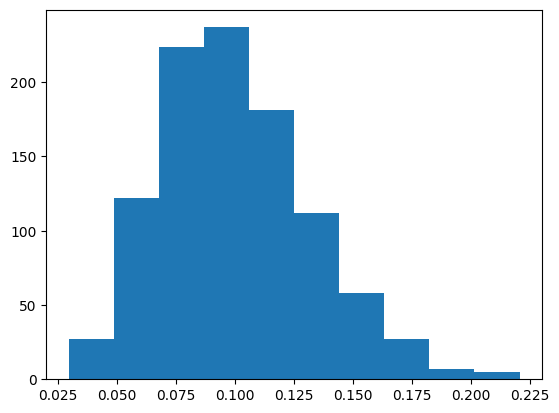

In [154]:
plt.hist(y.sample(sample_shape = torch.Size([1000])).numpy())

(array([1.646e+03, 1.418e+03, 1.136e+03, 9.600e+02, 8.180e+02, 6.760e+02,
        5.430e+02, 4.400e+02, 3.780e+02, 3.050e+02, 2.840e+02, 2.290e+02,
        2.150e+02, 1.680e+02, 1.090e+02, 1.160e+02, 9.600e+01, 8.400e+01,
        6.900e+01, 5.100e+01, 5.300e+01, 5.200e+01, 3.000e+01, 2.200e+01,
        1.500e+01, 1.500e+01, 1.000e+01, 1.100e+01, 7.000e+00, 7.000e+00,
        5.000e+00, 5.000e+00, 5.000e+00, 8.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.34895170e-06, 3.66503077e-03, 7.32871259e-03, 1.09923944e-02,
        1.46560762e-02, 1.83197580e-02, 2.19834399e-02, 2.56471217e-02,
        2.93108035e-02, 3.29744853e-02, 3.66381671e-02, 4.03018490e-02,
        4.39655308e-02, 4.76292126e-02, 5.12928944e-02, 5.49565762e-02,
        5.86202581e-02, 6.22839399e-02, 6.59476217e-02, 6.96113035e-02,
        7.327498

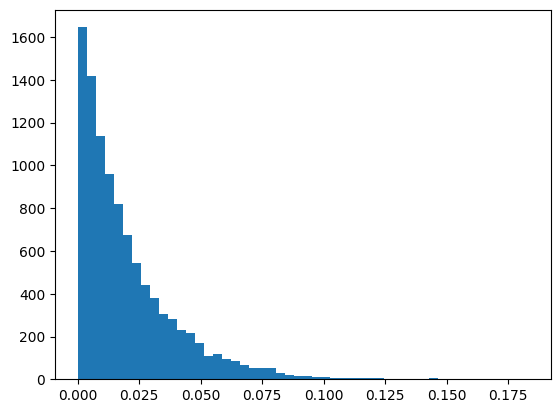

In [144]:
rate = 100
plt.hist(np.random.exponential(scale = 0.02, size = 10000), bins = 50)

In [147]:
torch.randn(100)

tensor([ 0.0758, -0.6860, -1.1836, -1.4931, -0.1507,  0.7741, -0.6926,  0.2041,
        -0.2915, -0.6343, -0.2146, -2.0826,  1.6723, -0.5464, -0.0080, -0.5735,
         1.8782, -0.3184, -1.0490,  0.1775,  0.6484,  1.1717,  0.2778,  1.3589,
        -1.5043, -0.6759, -1.1604,  0.0723,  0.8560, -0.5435,  0.9274,  0.2016,
        -1.1780,  0.2436, -0.0842,  0.6074,  0.2559, -1.7327, -0.2352, -0.1990,
        -2.0885, -0.0190,  0.2656,  0.8429, -0.0594,  0.1539, -0.4765, -0.0627,
        -2.4925,  1.3803,  2.0712, -0.6968, -1.6291, -0.0361, -0.6848, -0.4689,
        -0.2755,  1.0557,  1.2205,  0.5547, -1.4199, -0.3918, -1.4462,  0.9257,
        -0.7463, -0.4347,  0.7598, -0.3203, -1.0035, -0.3735, -0.1214,  0.2173,
         1.2164,  1.4971, -0.3741,  0.5593,  1.0478, -2.7564,  0.6424, -1.2841,
        -0.3940, -0.1286,  0.4840, -0.5230, -0.0802, -1.5716, -1.3050,  0.4422,
         1.8889,  0.2505,  0.4395, -0.5578, -0.7318,  1.3422, -0.2048, -0.6918,
         1.6142, -1.0927,  0.0198,  2.10

In [97]:
help(scipy.stats.gamma.rvs)

Help on method rvs in module scipy.stats._distn_infrastructure:

rvs(*args, **kwds) method of scipy.stats._continuous_distns.gamma_gen instance
    Random variates of given type.
    
    Parameters
    ----------
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information).
    loc : array_like, optional
        Location parameter (default=0).
    scale : array_like, optional
        Scale parameter (default=1).
    size : int or tuple of ints, optional
        Defining number of random variates (default is 1).
    random_state : {None, int, `numpy.random.Generator`,
                    `numpy.random.RandomState`}, optional
    
        If `seed` is None (or `np.random`), the `numpy.random.RandomState`
        singleton is used.
        If `seed` is an int, a new ``RandomState`` instance is used,
        seeded with `seed`.
        If `seed` is already a ``Generator`` or ``RandomState`` in

In [98]:
y = torch.rand(2)
y.tile(500 , 1).shape

torch.Size([500, 2])

In [193]:
y.shape + z.shape

torch.Size([2, 1, 4, 3])

value shape
torch.Size([500, 20, 2])
v shape
torch.Size([20])
logp out shape
torch.Size([500, 20])
value shape
torch.Size([500, 20, 2])
v shape
torch.Size([20])
logp out shape
torch.Size([500, 20])


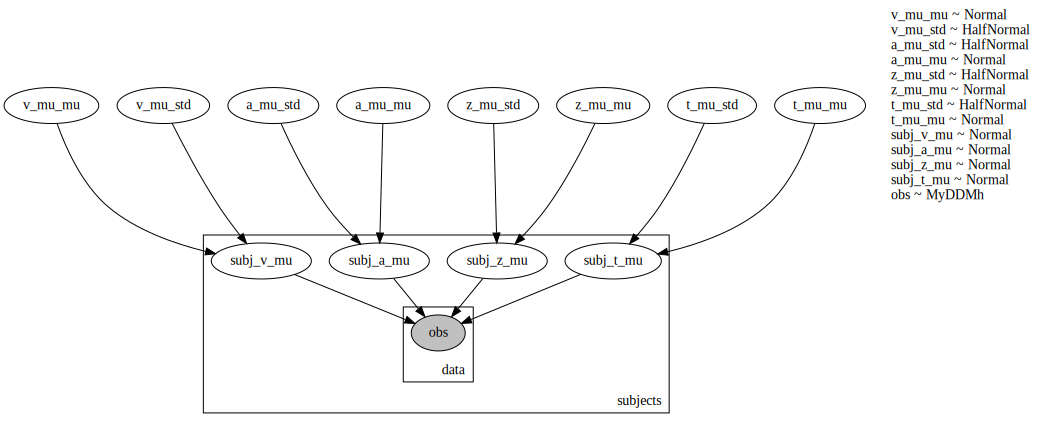

In [67]:
#import ipdb
pyro.render_model(hierarchical_ddm_model, 
                  model_args = (n_subjects, 
                                n_samples_by_subject, 
                                data), 
                  render_distributions = True, 
                  render_params = True)

torch.Size([20])


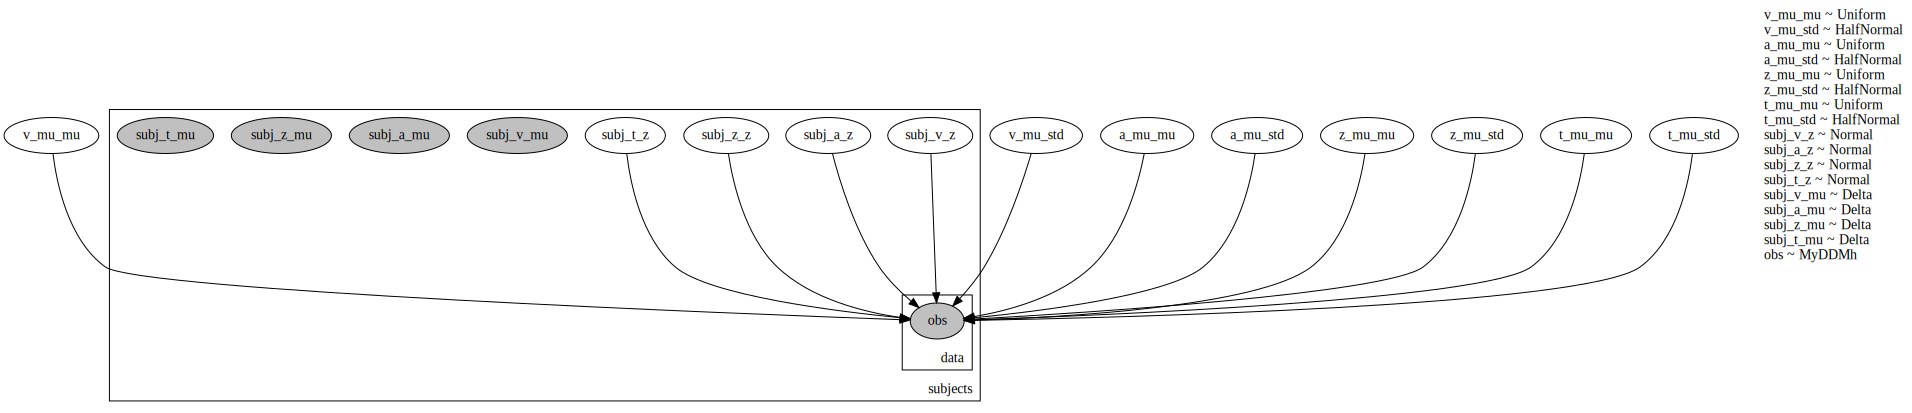

In [176]:
#import ipdb
pyro.render_model(hierarchical_noncentered_ddm_model, 
                  model_args = (n_subjects, 
                                n_samples_by_subject, 
                                data),
                  render_distributions = True,
                  render_params = True)

### Sample / NUTS

#### Centered

In [211]:
torch.tensor(param_dict['t_subj']).repeat(1, 1)

torch.Size([1, 20])

In [14]:
# NUTS VERSION
from pyro.infer import MCMC, NUTS
#torch_data = torch.tensor(out)
num_chains = 1

nuts_kernel = NUTS(hierarchical_ddm_model,
                   step_size = 0.01,
                   max_tree_depth = 5)
                   #jit_compile = True,
                   #ignore_jit_warnings = True)
                   #max_tree_depth = 1)

mcmc = MCMC(nuts_kernel, 
            num_samples = 100, 
            warmup_steps = 100, 
            num_chains = num_chains, 
            initial_params = {'v_mu_mu': torch.tensor(param_dict['v_mu']).repeat(num_chains, 1),
                              'v_mu_std': torch.tensor(param_dict['v_std']).repeat(num_chains, 1),
                              'a_mu_mu': torch.tensor(param_dict['a_mu']).repeat(num_chains, 1),
                              'a_mu_std': torch.tensor(param_dict['a_std']).repeat(num_chains, 1),
                              'z_mu_mu': torch.tensor(param_dict['z_mu']).repeat(num_chains, 1),
                              'z_mu_std': torch.tensor(param_dict['z_std']).repeat(num_chains, 1),
                              't_mu_mu': torch.tensor(param_dict['t_mu']).repeat(num_chains, 1),
                              't_mu_std': torch.tensor(param_dict['t_std']).repeat(num_chains, 1),
                              'v_subj': torch.tensor(param_dict['v_subj']).repeat(num_chains, 1),
                              'a_subj': torch.tensor(param_dict['a_subj']).repeat(num_chains, 1),
                              'z_subj': torch.tensor(param_dict['z_subj']).repeat(num_chains, 1),
                              't_subj': torch.tensor(param_dict['t_subj']).repeat(num_chains, 1),
                              }
           )
mcmc.run(n_subjects, n_samples_by_subject, data)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

hmc_samples_new = {}
#hmc_samples_new['v'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['a'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['z'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['t'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['g_mu_std'] = np.expand_dims(hmc_samples['g_mu_std'], axis = (1,2))
#hmc_samples_new['subj_mu'] = np.expand_dims(hmc_samples['subj_mu'], axis = 1)

Sample: 100%|██████████| 200/200 [01:50,  1.81it/s, step size=5.08e-02, acc. prob=0.828]


In [16]:
import cloudpickle as cpickle

In [18]:
cpickle.dump(mcmc, open('pyro_save_test.pyro', 'wb'))

In [20]:
mcmc_loaded = cpickle.load(open('pyro_save_test.pyro', 'rb'))

In [21]:
import arviz as az

In [206]:
# NUTS VERSION
from pyro.infer import MCMC, NUTS
#torch_data = torch.tensor(out)

nuts_kernel = NUTS(hierarchical_ddm_model,
                   step_size = 0.01,
                   max_tree_depth = 5)
                   #jit_compile = True,
                   #ignore_jit_warnings = True)
                   #max_tree_depth = 1)

mcmc = MCMC(nuts_kernel, 
            num_samples = 100, 
            warmup_steps = 100, 
            num_chains = 1, 
            initial_params = {'v_mu_mu': torch.tensor(param_dict['v_mu']),
                              'v_mu_std': torch.tensor(param_dict['v_std']),
                              'a_mu_mu': torch.tensor(param_dict['a_mu']),
                              'a_mu_std': torch.tensor(param_dict['a_std']),
                              'z_mu_mu': torch.tensor(param_dict['z_mu']),
                              'z_mu_std': torch.tensor(param_dict['z_std']),
                              't_mu_mu': torch.tensor(param_dict['t_mu']),
                              't_mu_std': torch.tensor(param_dict['t_std']),
                              'v_subj': torch.tensor(param_dict['v_subj']),
                              'a_subj': torch.tensor(param_dict['a_subj']),
                              'z_subj': torch.tensor(param_dict['z_subj']),
                              't_subj': torch.tensor(param_dict['t_subj']),
                              }
           )
mcmc.run(n_subjects, n_samples_by_subject, data)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

hmc_samples_new = {}
#hmc_samples_new['v'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['a'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['z'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['t'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['g_mu_std'] = np.expand_dims(hmc_samples['g_mu_std'], axis = (1,2))
#hmc_samples_new['subj_mu'] = np.expand_dims(hmc_samples['subj_mu'], axis = 1)

Warmup:   2%|▏         | 3/200 [00:02,  1.20it/s, step size=1.43e-03, acc. prob=0.355]

KeyboardInterrupt: 

In [181]:
param_dict.keys()

dict_keys(['v_mu', 'v_std', 'v_subjects', 'a_mu', 'a_std', 'a_subjects', 'z_mu', 'z_std', 'z_subjects', 't_mu', 't_std', 't_subjects'])

In [182]:
param_dict

{'v_mu': 0.074449174,
 'v_std': 0.16536614,
 'v_subjects': array([ 0.30066875,  0.0786009 ,  0.0090498 ,  0.2868434 ,  0.1672654 ,
         0.11409166,  0.15380824,  0.08466102, -0.10257731, -0.13609664,
         0.2265986 ,  0.24889697,  0.16379453,  0.12555781,  0.23499675,
         0.26540145,  0.14433436,  0.23968449,  0.2205535 , -0.01322781],
       dtype=float32),
 'a_mu': 0.9268145,
 'a_std': 0.06799549,
 'a_subjects': array([0.8994963 , 1.0587475 , 0.8422006 , 0.9906833 , 0.9104406 ,
        0.94522816, 0.8523227 , 1.0900949 , 0.9077819 , 1.0648998 ,
        0.92124295, 0.8439534 , 0.8719509 , 1.0164354 , 0.88746965,
        0.93239367, 1.0217301 , 1.0003774 , 0.8576929 , 0.9069599 ],
       dtype=float32),
 'z_mu': 0.55008066,
 'z_std': 0.021121053,
 'z_subjects': array([0.5237771 , 0.55651295, 0.53744227, 0.55267996, 0.53337735,
        0.5636804 , 0.5488208 , 0.5693694 , 0.5270465 , 0.5463876 ,
        0.57258046, 0.5762123 , 0.5716198 , 0.5682593 , 0.53461087,
        0.55

In [180]:
hmc_samples.keys()

dict_keys(['a_mu_mu', 'a_mu_std', 'subj_a_mu', 'subj_t_mu', 'subj_v_mu', 'subj_z_mu', 't_mu_mu', 't_mu_std', 'v_mu_mu', 'v_mu_std', 'z_mu_mu', 'z_mu_std'])

In [ ]:
hmc_samples.keys()

In [189]:
hmc_samples['subj_v_mu'].mean(axis = 0)

array([ 0.28045312, -0.00290187,  0.05078039,  0.30843392,  0.15132928,
        0.14299703,  0.15890175,  0.04985668,  0.02284678, -0.05311567,
        0.12789455,  0.20260686,  0.24523318,  0.14472143,  0.24350509,
        0.15939087,  0.1362527 ,  0.1949281 ,  0.15406664,  0.12569422],
      dtype=float32)

#### Non-centered

In [197]:
# NUTS VERSION
from pyro.infer import MCMC, NUTS
#torch_data = torch.tensor(out)

nuts_kernel = NUTS(hierarchical_noncentered_ddm_model,
                   step_size = 0.01,
                   max_tree_depth = 5)
                   #jit_compile = True,
                   #ignore_jit_warnings = True)
                   #max_tree_depth = 1)

mcmc = MCMC(nuts_kernel, 
            num_samples = 1000, 
            warmup_steps = 1000, 
            num_chains = 1, 
            initial_params = {'v_mu_mu': torch.tensor(0.0),
                              'v_mu_std': torch.tensor(10.0),
                              'a_mu_mu': torch.tensor(1.0),
                              'a_mu_std': torch.tensor(10.),
                              'z_mu_mu': torch.tensor(0.5),
                              'z_mu_std': torch.tensor(10.0),
                              't_mu_mu': torch.tensor(0.5),
                              't_mu_std': torch.tensor(10.0),
                              'v_subj_z': (torch.rand(20) / 10),
                              'a_subj_z': (torch.rand(20) / 10),
                              'z_subj_z': (torch.rand(20) / 10),
                              't_subj_z': (torch.rand(20) / 10),
                              }
           )
mcmc.run(n_subjects, n_samples_by_subject, data)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

hmc_samples_new = {}
#hmc_samples_new['v'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['a'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['z'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['t'] = np.expand_dims(hmc_samples['v'], axis = (1))
#hmc_samples_new['g_mu_std'] = np.expand_dims(hmc_samples['g_mu_std'], axis = (1,2))
#hmc_samples_new['subj_mu'] = np.expand_dims(hmc_samples['subj_mu'], axis = 1)

Warmup:  20%|██        | 404/2000 [07:39,  1.07s/it, step size=1.34e-01, acc. prob=0.794]

KeyboardInterrupt: 

In [189]:
param_dict['t_mu']

(1.165789028764945,)

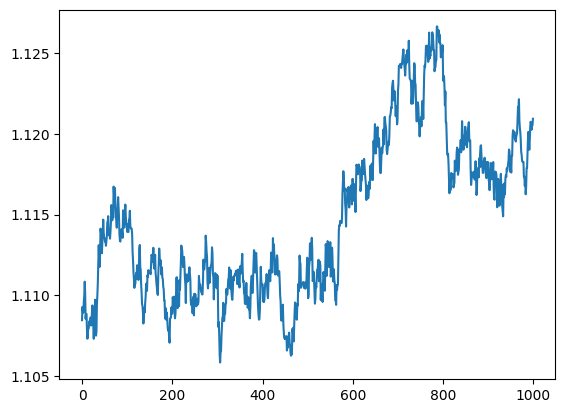

In [190]:
plt.plot(hmc_samples['t_mu_mu'])

(array([3.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 4.00e+00,
        6.00e+00, 1.00e+01, 1.50e+01, 2.20e+01, 2.90e+01, 4.70e+01,
        1.06e+02, 2.27e+02, 4.91e+02, 6.93e+02, 1.02e+03, 8.97e+02,
        6.59e+02, 4.17e+02, 1.77e+02, 8.40e+01, 3.50e+01, 2.00e+01,
        1.70e+01, 6.00e+00, 6.00e+00, 3.00e+00, 3.00e+00, 1.00e+00]),
 array([1.03719118, 1.04553313, 1.05387508, 1.06221703, 1.07055898,
        1.07890093, 1.08724288, 1.09558483, 1.10392678, 1.11226873,
        1.12061068, 1.12895263, 1.13729458, 1.14563653, 1.15397848,
        1.16232043, 1.17066238, 1.17900433, 1.18734628, 1.19568823,
        1.20403018, 1.21237213, 1.22071408, 1.22905603, 1.23739798,
        1.24573993, 1.25408188, 1.26242383, 1.27076578, 1.27910773,
        1.28744968]),
 <BarContainer object of 30 artists>)

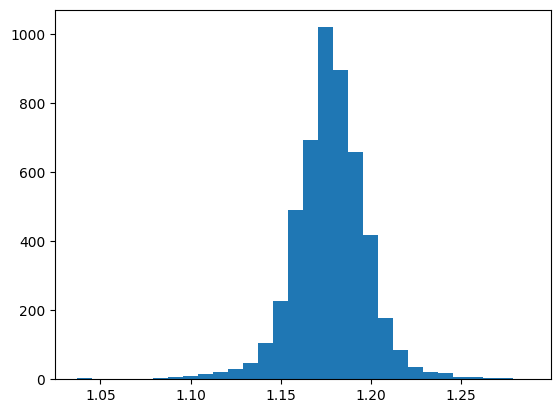

In [103]:
plt.hist(hmc_samples['t_mu_mu'], bins = 30)

(array([ 30.,  45.,  55., 151., 212., 257., 148.,  56.,  30.,  16.]),
 array([-0.84129277, -0.82021188, -0.79913098, -0.77805009, -0.7569692 ,
        -0.7358883 , -0.71480741, -0.69372651, -0.67264562, -0.65156473,
        -0.63048383]),
 <BarContainer object of 10 artists>)

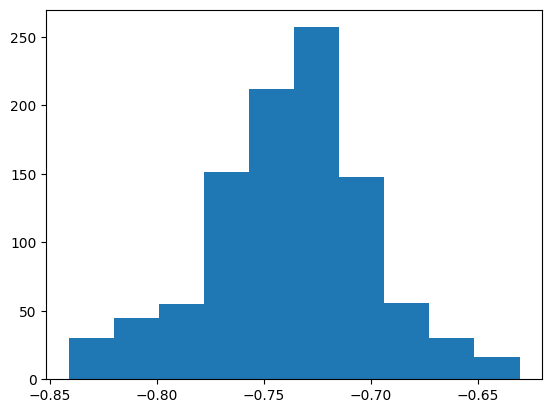

In [58]:
plt.hist(hmc_samples['subj_v_mu'][:, 3])

In [23]:
help(pyro.infer.Predictive)

Help on class Predictive in module pyro.infer.predictive:

class Predictive(torch.nn.modules.module.Module)
 |  Predictive(model, posterior_samples=None, guide=None, num_samples=None, return_sites=(), parallel=False)
 |  
 |  EXPERIMENTAL class used to construct predictive distribution. The predictive
 |  distribution is obtained by running the `model` conditioned on latent samples
 |  from `posterior_samples`. If a `guide` is provided, then posterior samples
 |  from all the latent sites are also returned.
 |  
 |  .. warning::
 |      The interface for the :class:`Predictive` class is experimental, and
 |      might change in the future.
 |  
 |  :param model: Python callable containing Pyro primitives.
 |  :param dict posterior_samples: dictionary of samples from the posterior.
 |  :param callable guide: optional guide to get posterior samples of sites not present
 |      in `posterior_samples`.
 |  :param int num_samples: number of samples to draw from the predictive distribution.


### Sample Variational

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.MyDDMh'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')
Guessed max_plate_nesting = 3
Step 0 out of 200, Elbo loss: 447293.9716525078
Step 100 out of 200, Elbo loss: 217303.04555683135


CPU times: user 40.1 s, sys: 24.8 s, total: 1min 4s
Wall time: 1min 5s


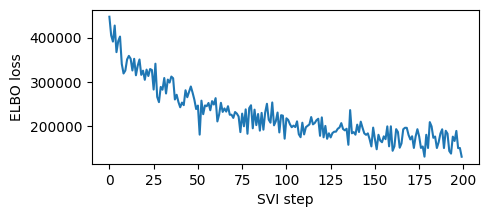

In [26]:
%%time
pyro.clear_param_store()
#torch_data = torch.tensor(out)
steps = 200

# These should be reset each training loop.
#auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(basic_ddm_model)
adam = pyro.optim.Adam({"lr": 0.02})
#elbo = pyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
elbo = pyro.infer.Trace_ELBO(num_particles = 10, vectorize_particles = True)
#elbo = pyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
#svi = pyro.infer.SVI(basic_hierarchical_model, auto_guide, adam, elbo)

svi = pyro.infer.SVI(hierarchical_ddm_model, hierarchical_ddm_guide, adam, elbo)
losses = []
for step in range(steps if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(*(n_subjects, n_samples_by_subject, data))
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Step {} out of {}, Elbo loss: {}".format(step, steps, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step");
plt.ylabel("ELBO loss");

#predictive = pyro.infer.Predictive(basic_hierarchical_model, guide = auto_guide, num_samples = 1000)
predictive = pyro.infer.Predictive(hierarchical_ddm_model, guide = hierarchical_ddm_guide, num_samples = 1000)
svi_samples = predictive(n_subjects, n_samples_by_subject, data) #torch.tensor(data))

In [32]:
svi_samples['obs'].shape

torch.Size([1000, 500, 20, 2])

In [33]:
svi_samples = predictive(n_subjects, n_samples_by_subject, data) #torch.tensor(data))

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.,  0.,  1.,  2.,  4.,  3.,
         2.,  6.,  5.,  4.,  4.,  7.,  4., 11.,  8., 11., 16., 14., 17.,
        18., 23., 19., 30., 31., 49., 49., 57., 44., 36., 17.]),
 array([-5.0829086 , -4.9959316 , -4.908954  , -4.821977  , -4.735     ,
        -4.648023  , -4.5610456 , -4.4740686 , -4.3870916 , -4.3001146 ,
        -4.213137  , -4.12616   , -4.039183  , -3.952206  , -3.865229  ,
        -3.7782516 , -3.6912746 , -3.6042974 , -3.5173204 , -3.4303432 ,
        -3.3433661 , -3.256389  , -3.169412  , -3.0824347 , -2.9954576 ,
        -2.9084804 , -2.8215034 , -2.7345262 , -2.6475492 , -2.560572  ,
        -2.473595  , -2.3866177 , -2.2996407 , -2.2126634 , -2.1256864 ,
        -2.0387092 , -1.951732  , -1.8647549 , -1.7777778 , -1.6908007 ,
        -1.6038235 , -1.5168464 , -1.4298693 , -1.3428922 , -1.255915  ,
        -1.1689379 , -1.0819608 , -0.9949837 , -0.90800655,

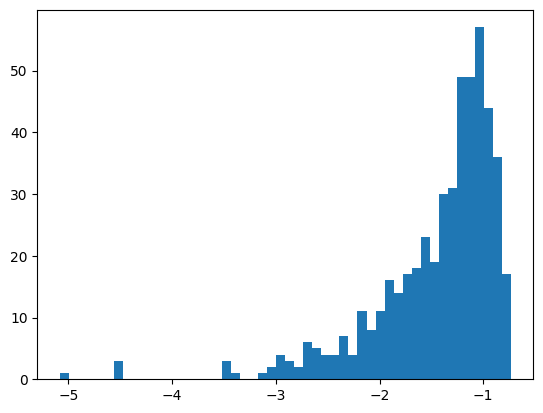

In [41]:
plt.hist(svi_samples['obs'][0, :, 0, 0].numpy() * svi_samples['obs'][0, :, 0, 1].numpy(),
         bins = 50)

(array([  3.,  14.,  71., 171., 281., 232., 140.,  69.,  16.,   3.]),
 array([-0.0683161 ,  0.04809742,  0.16451094,  0.28092447,  0.39733797,
         0.5137515 ,  0.63016504,  0.7465786 ,  0.86299205,  0.9794056 ,
         1.0958191 ], dtype=float32),
 <BarContainer object of 10 artists>)

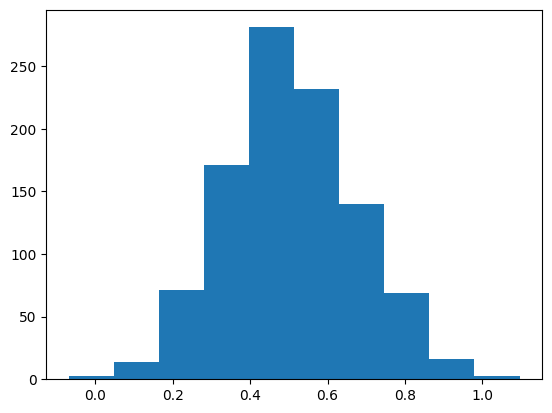

In [52]:
plt.hist(svi_samples['t_subj'][:, 0, 5].numpy())

In [46]:
svi_samples['t_subj'].shape

torch.Size([1000, 1, 20])

In [172]:
param_dict

{'v_mu': 0.074449174,
 'v_std': 0.16536614,
 'v_subjects': array([ 0.30066875,  0.0786009 ,  0.0090498 ,  0.2868434 ,  0.1672654 ,
         0.11409166,  0.15380824,  0.08466102, -0.10257731, -0.13609664,
         0.2265986 ,  0.24889697,  0.16379453,  0.12555781,  0.23499675,
         0.26540145,  0.14433436,  0.23968449,  0.2205535 , -0.01322781],
       dtype=float32),
 'a_mu': 0.9268145,
 'a_std': 0.06799549,
 'a_subjects': array([0.8994963 , 1.0587475 , 0.8422006 , 0.9906833 , 0.9104406 ,
        0.94522816, 0.8523227 , 1.0900949 , 0.9077819 , 1.0648998 ,
        0.92124295, 0.8439534 , 0.8719509 , 1.0164354 , 0.88746965,
        0.93239367, 1.0217301 , 1.0003774 , 0.8576929 , 0.9069599 ],
       dtype=float32),
 'z_mu': 0.55008066,
 'z_std': 0.021121053,
 'z_subjects': array([0.5237771 , 0.55651295, 0.53744227, 0.55267996, 0.53337735,
        0.5636804 , 0.5488208 , 0.5693694 , 0.5270465 , 0.5463876 ,
        0.57258046, 0.5762123 , 0.5716198 , 0.5682593 , 0.53461087,
        0.55

(array([ 35., 160., 255., 249., 169.,  87.,  32.,  12.,   0.,   1.]),
 array([0.0755928 , 0.10796805, 0.1403433 , 0.17271854, 0.20509379,
        0.23746902, 0.26984426, 0.3022195 , 0.33459476, 0.36697   ,
        0.39934525], dtype=float32),
 <BarContainer object of 10 artists>)

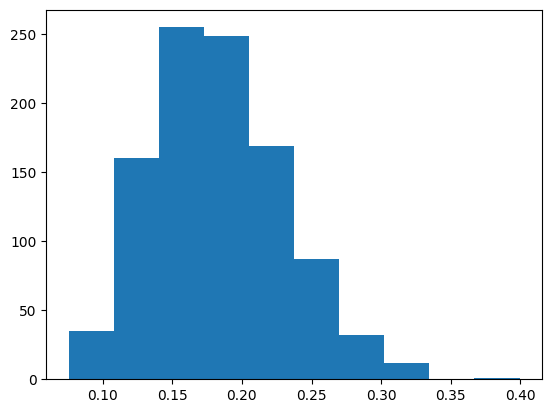

In [176]:
plt.hist(svi_samples['t_mu_std'].squeeze().numpy())

(array([  4.,  23.,  89., 171., 249., 271., 136.,  45.,  11.,   1.]),
 array([0.53129476, 0.5350916 , 0.53888845, 0.5426853 , 0.5464821 ,
        0.5502789 , 0.5540758 , 0.5578726 , 0.5616694 , 0.5654663 ,
        0.5692631 ], dtype=float32),
 <BarContainer object of 10 artists>)

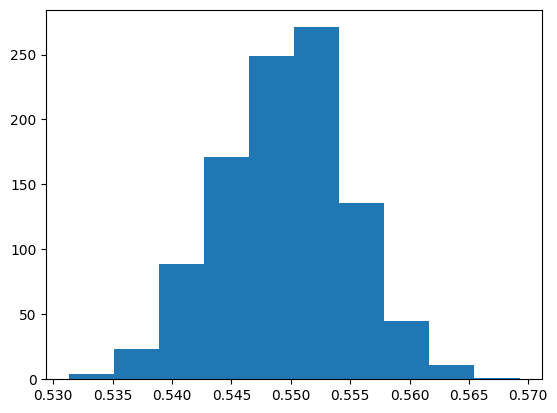

In [158]:
plt.hist(svi_samples['z_mu_mu'].squeeze().numpy())

(array([  2.,   0.,  10.,  63., 172., 272., 288., 139.,  45.,   9.]),
 array([-0.10400686, -0.06829887, -0.03259088,  0.00311711,  0.0388251 ,
         0.07453309,  0.11024108,  0.14594907,  0.18165706,  0.21736504,
         0.25307304], dtype=float32),
 <BarContainer object of 10 artists>)

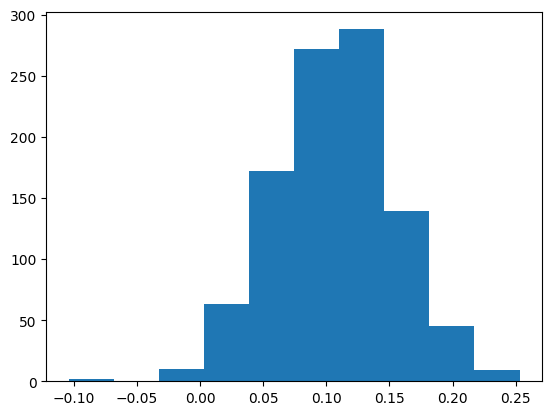

In [168]:
plt.hist(svi_samples['subj_v_mu'].squeeze().numpy()[:, 19])

In [165]:
svi_samples['subj_v_mu'].squeeze().numpy().mean(axis = 0)

array([ 0.30120668, -0.00827327,  0.03417129,  0.30502677,  0.14382598,
        0.15117773,  0.16595031,  0.05464168,  0.00442458, -0.05814843,
        0.12100247,  0.20075232,  0.23252746,  0.12860318,  0.2577743 ,
        0.17085941,  0.12284482,  0.19174644,  0.17013904,  0.10689212],
      dtype=float32)

In [166]:
param_dict['v_subjects']

array([ 0.30066875,  0.0786009 ,  0.0090498 ,  0.2868434 ,  0.1672654 ,
        0.11409166,  0.15380824,  0.08466102, -0.10257731, -0.13609664,
        0.2265986 ,  0.24889697,  0.16379453,  0.12555781,  0.23499675,
        0.26540145,  0.14433436,  0.23968449,  0.2205535 , -0.01322781],
      dtype=float32)

In [88]:
data.shape

torch.Size([500, 20, 2])

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Guessed max_plate_nesting = 2
Step 0 out of 2000, Elbo loss: 13417.54596272111
Step 100 out of 2000, Elbo loss: -11702.706844300032
Step 200 out of 2000, Elbo loss: -21727.80176898837
Step 300 out of 2000, Elbo loss: -35647.11387595534
Step 400 out of 2000, Elbo loss: -20409.475065857172
Step 500 out of 2000, Elbo loss: -31144.538378089666
Step 600 out of 2000, Elbo loss: -40313.98530378938
Step 700 out of 2000, Elbo loss: -40255.28565129638
Step 800 out of 2000, Elbo loss: -40573.67958423495
Step 900 out of 2000, Elbo loss: -37778.76841285825
Step 1000 out of 2000, Elbo loss: -41171.83035573363
Step 1100 out of 2000, Elbo loss: -55505.41206559539
Step 1200 out of 2000, Elbo loss: -

CPU times: user 1min 4s, sys: 32.8 s, total: 1min 37s
Wall time: 1min 37s


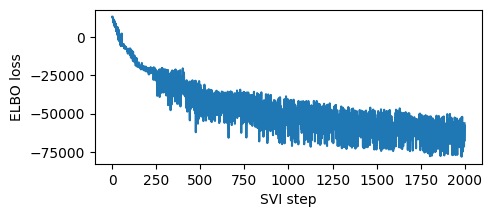

In [65]:
%%time
pyro.clear_param_store()
torch_data = torch.tensor(out)
steps = 2000

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(hierarchical_ddm_model)
adam = pyro.optim.Adam({"lr": 0.02})
#elbo = pyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
elbo = pyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
#elbo = pyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
#svi = pyro.infer.SVI(basic_hierarchical_model, auto_guide, adam, elbo)

svi = pyro.infer.SVI(hierarchical_ddm_model, auto_guide, adam, elbo)
losses = []
for step in range(steps if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(*(n_subjects, n_samples_by_subject, data))
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Step {} out of {}, Elbo loss: {}".format(step, steps, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step");
plt.ylabel("ELBO loss");

#predictive = pyro.infer.Predictive(basic_hierarchical_model, guide = auto_guide, num_samples = 1000)
predictive = pyro.infer.Predictive(hierarchical_ddm_model, guide = auto_guide, num_samples = 1000)
svi_samples = predictive(20, 500, data) #torch.tensor(data))

In [44]:
param_dict

{'v_mu': 0.074449174,
 'v_std': 0.16536614,
 'v_subjects': array([ 0.30066875,  0.0786009 ,  0.0090498 ,  0.2868434 ,  0.1672654 ,
         0.11409166,  0.15380824,  0.08466102, -0.10257731, -0.13609664,
         0.2265986 ,  0.24889697,  0.16379453,  0.12555781,  0.23499675,
         0.26540145,  0.14433436,  0.23968449,  0.2205535 , -0.01322781],
       dtype=float32),
 'a_mu': 0.9268145,
 'a_std': 0.06799549,
 'a_subjects': array([0.8994963 , 1.0587475 , 0.8422006 , 0.9906833 , 0.9104406 ,
        0.94522816, 0.8523227 , 1.0900949 , 0.9077819 , 1.0648998 ,
        0.92124295, 0.8439534 , 0.8719509 , 1.0164354 , 0.88746965,
        0.93239367, 1.0217301 , 1.0003774 , 0.8576929 , 0.9069599 ],
       dtype=float32),
 'z_mu': 0.55008066,
 'z_std': 0.021121053,
 'z_subjects': array([0.5237771 , 0.55651295, 0.53744227, 0.55267996, 0.53337735,
        0.5636804 , 0.5488208 , 0.5693694 , 0.5270465 , 0.5463876 ,
        0.57258046, 0.5762123 , 0.5716198 , 0.5682593 , 0.53461087,
        0.55

In [47]:
svi_samples.keys()

dict_keys(['v_mu_mu', 'v_mu_std', 'a_mu_mu', 'a_mu_std', 'z_mu_mu', 'z_mu_std', 't_mu_mu', 't_mu_std', 'subj_v_mu', 'subj_a_mu', 'subj_z_mu', 'subj_t_mu', 'obs'])

In [49]:
svi_samples['subj_v_mu'].shape

torch.Size([1000, 1, 20])

(array([  1.,  17.,  36.,  98., 208., 245., 237., 109.,  37.,  12.]),
 array([-6.69426  , -6.609806 , -6.5253515, -6.4408975, -6.3564434,
        -6.271989 , -6.187535 , -6.1030807, -6.0186267, -5.934172 ,
        -5.849718 ], dtype=float32),
 <BarContainer object of 10 artists>)

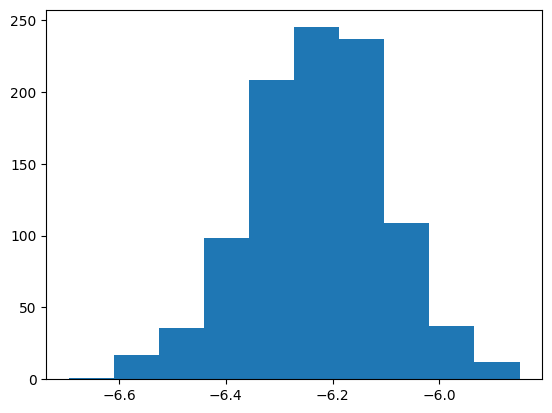

In [60]:
plt.hist(svi_samples['subj_v_mu'].squeeze()[:, 10].numpy())

In [ ]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def basic_hierarchical_model(num_subjects, num_trials, data):
    g_mu_mu = pyro.sample("g_mu_mu", dist.Normal(0., 100.))
    g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
    #g_mu_std = pyro.sample("g_mu_std", dist.HalfNormal(100.))
    #g_std_mu = pyro.sample("g_std_mu", dist.HalfNormal(100.))
    #g_std_std = pyro.sample("g_std_std", dist.HalfNormal(100.))
    
    with pyro.plate("subjects", num_subjects) as subjects_plate:
        subj_mu = pyro.sample("subj_mu", dist.Normal(g_mu_mu, g_mu_std))
        #subj_std = pyro.sample("subj_std", dist.LogNormal(g_std_mu, g_std_std))
        with pyro.plate("data", num_trials) as data_plate:
            return pyro.sample("obs", dist.Normal(subj_mu, torch.tensor(10)), obs = data)

## Historical

In [49]:
#svi_samples['v'].squeeze().numpy()

(array([ 0.34003695,  0.72865061,  1.65160805,  5.3920145 , 10.44399206,
        15.4473929 ,  9.18099767,  3.49752292,  1.16584097,  0.72865061]),
 array([0.36340134, 0.38398733, 0.40457333, 0.42515933, 0.44574533,
        0.46633133, 0.48691732, 0.50750332, 0.52808932, 0.54867532,
        0.56926132]),
 [<matplotlib.patches.Polygon at 0x7fd30748e910>])

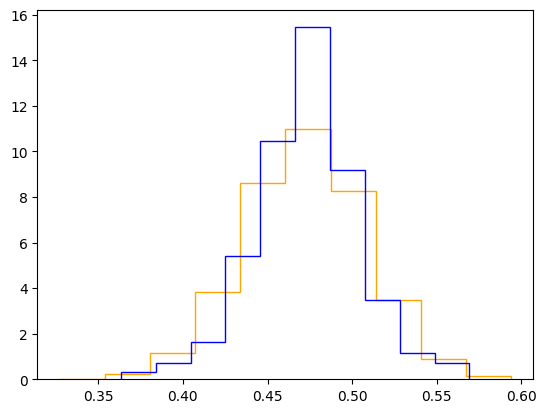

In [61]:
plt.hist(svi_samples['v'].squeeze().numpy(), histtype = 'step', color = 'orange', label = 'variational', density = True)
plt.hist(hmc_samples['v'], histtype = 'step', color = 'blue', label = 'hmc', density = True)

{'g_mu_mu': array([0]), 'g_mu_std': array([0.25]), 'subj_mu': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
       -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
       -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
        7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
        3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01])}
g_mu_mu
torch.Size([1000, 1, 1])
[0]
0


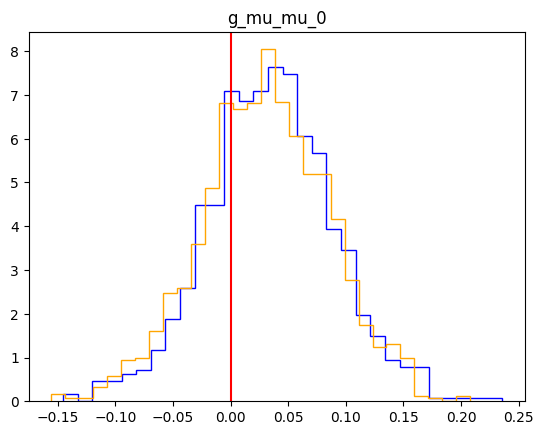

Warmup:   0%|          | 0/2200 [14:14, ?it/s]

{'g_mu_mu': array([0]), 'g_mu_std': array([0.25]), 'subj_mu': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
       -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
       -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
        7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
        3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01])}
g_mu_std
torch.Size([1000, 1, 1])
[0.25]
0.25


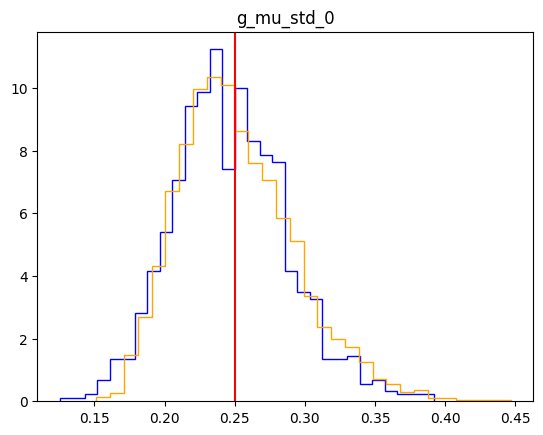

{'g_mu_mu': array([0]), 'g_mu_std': array([0.25]), 'subj_mu': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
       -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
       -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
        7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
        3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01])}
subj_mu
torch.Size([1000, 1, 20])
[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.0002771386780527433


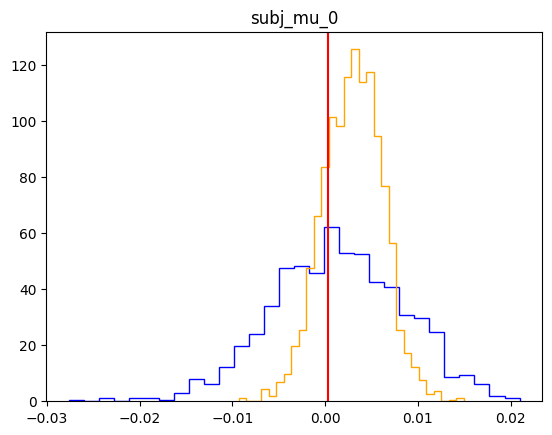

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.0723860173125497


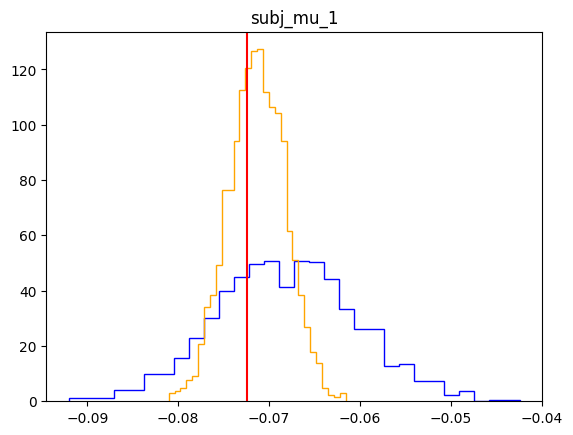

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.27901657576610356


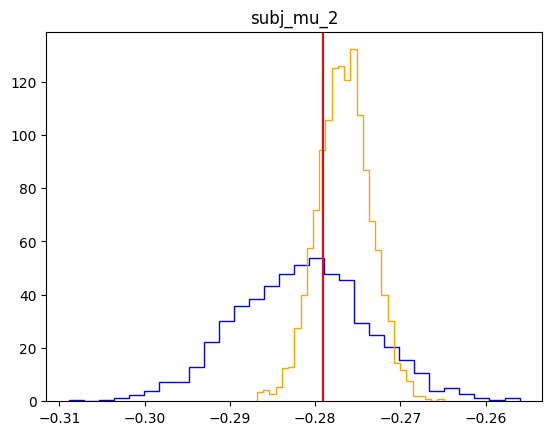

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.0032206891864485737


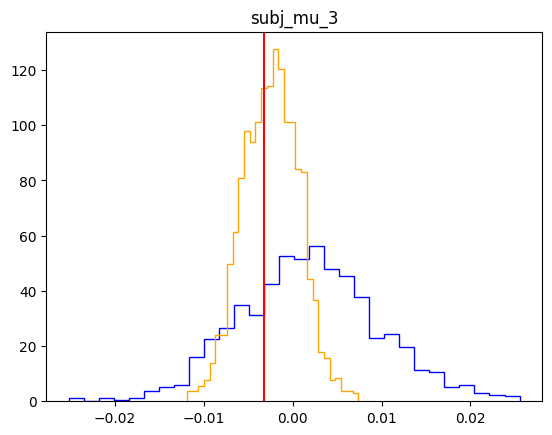

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.09459036605197953


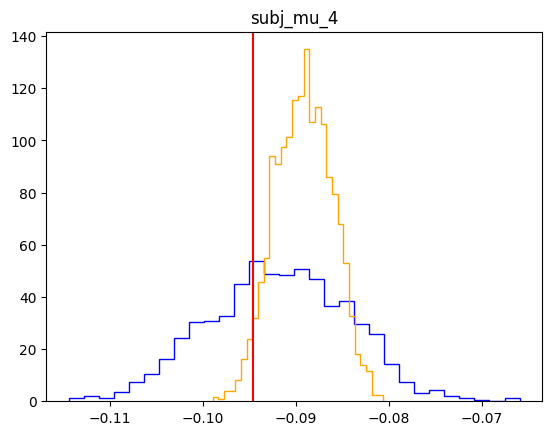

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.12028384071922597


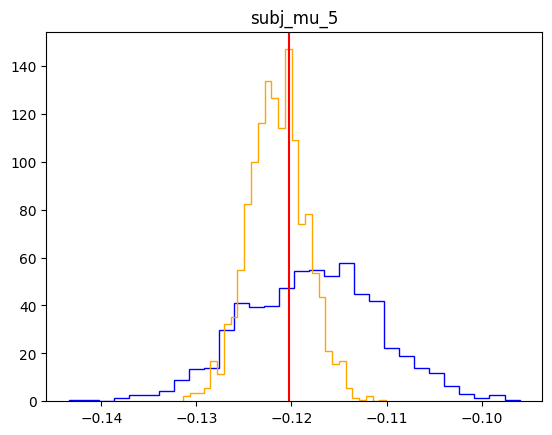

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.379332794698918


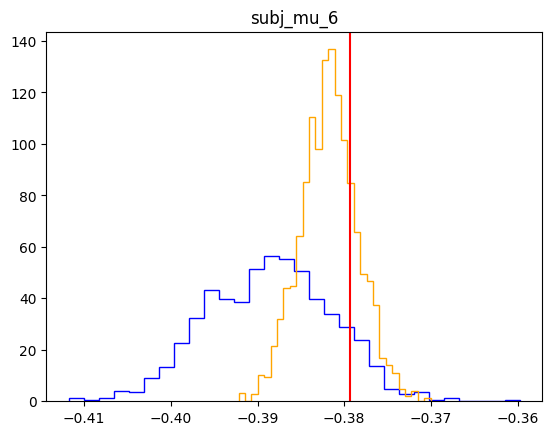

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.12271799530543662


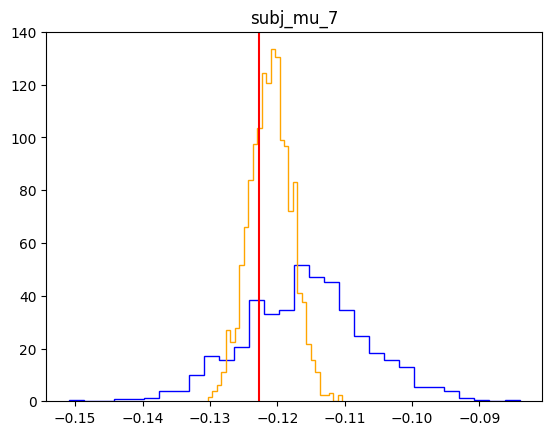

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.06017014462566819


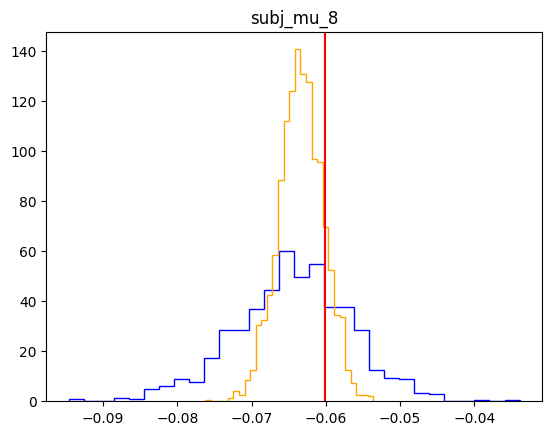

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.1619868650554009


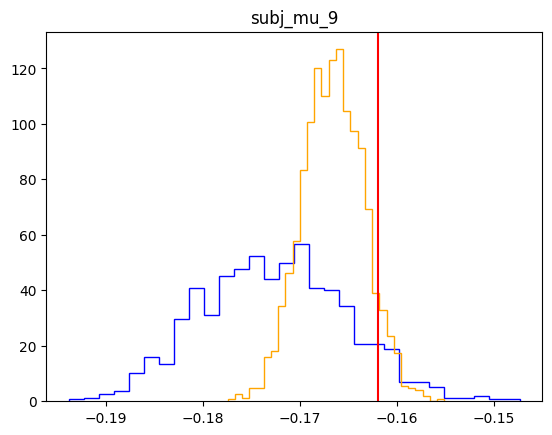

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.15897277006170793


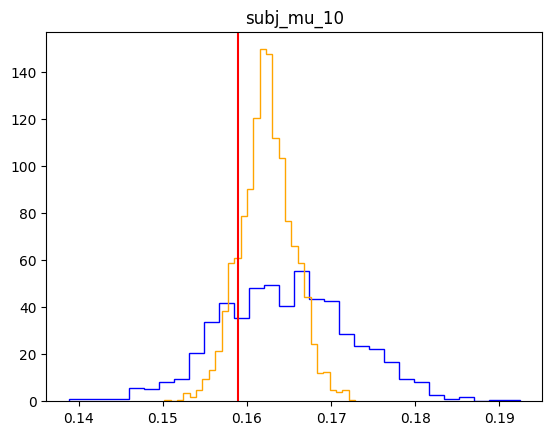

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.43502932632129415


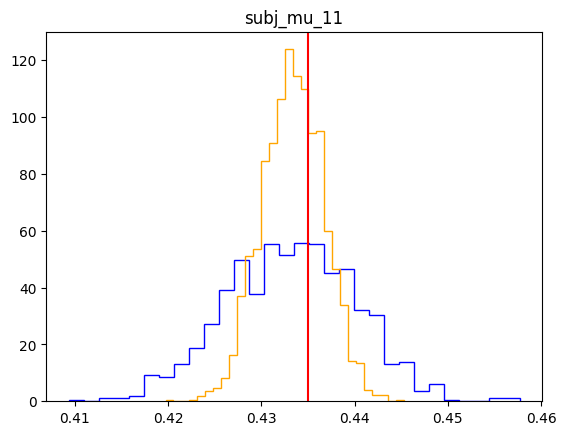

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.07417055442785082


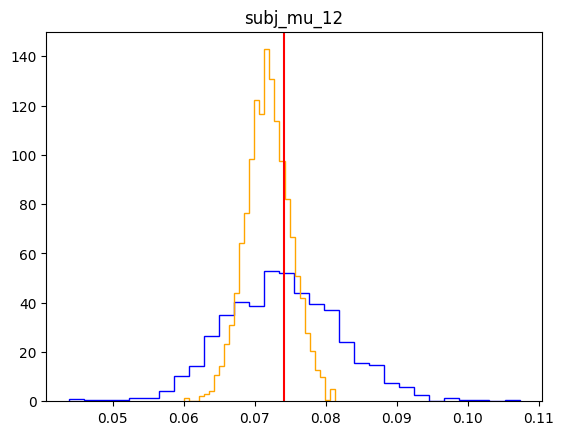

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.17687591546297207


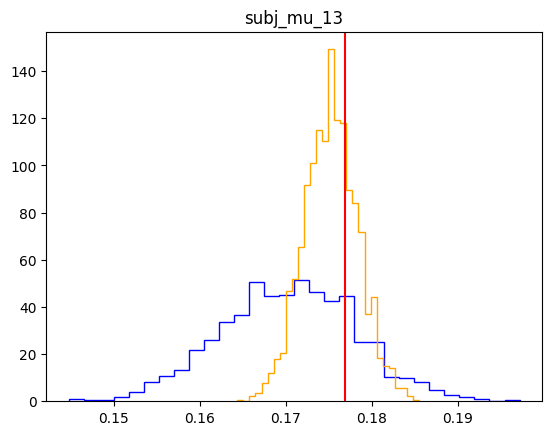

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.45570394077955917


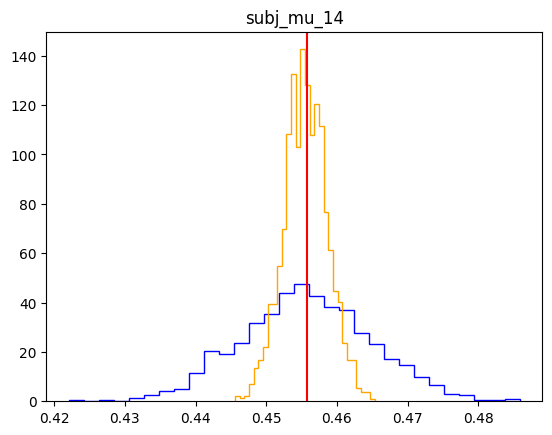

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.10769225737472315


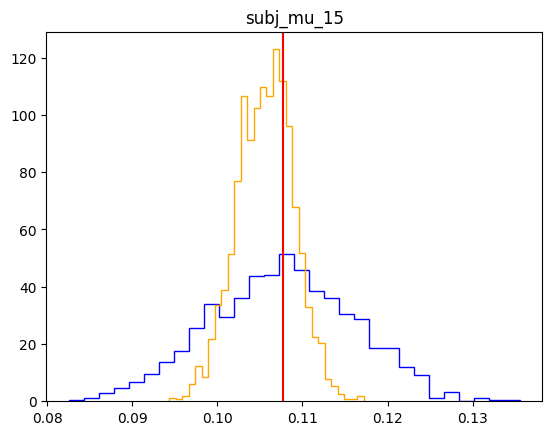

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.3856824063720217


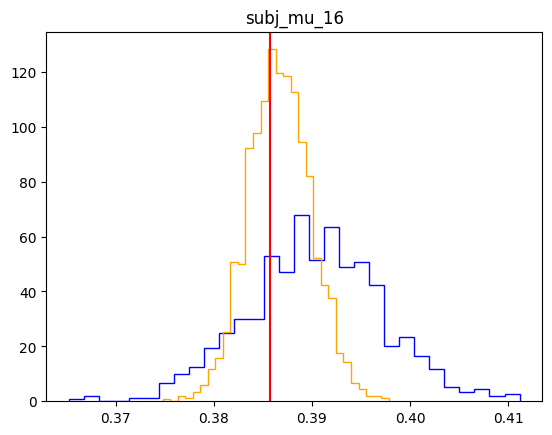

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.22518029285417218


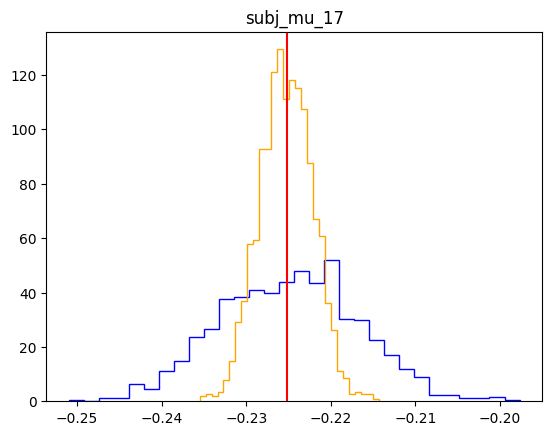

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
-0.034281252594501335


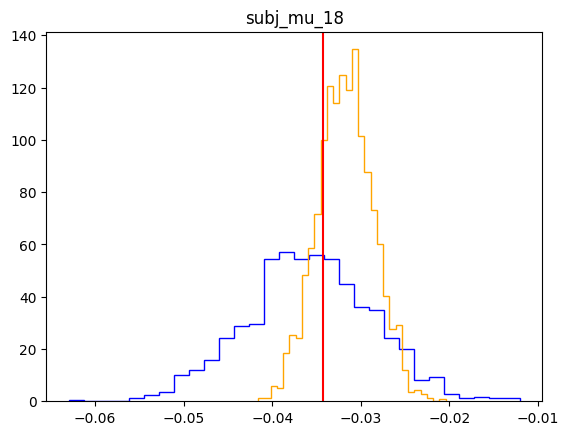

[ 2.77138678e-04 -7.23860173e-02 -2.79016576e-01 -3.22068919e-03
 -9.45903661e-02 -1.20283841e-01 -3.79332795e-01 -1.22717995e-01
 -6.01701446e-02 -1.61986865e-01  1.58972770e-01  4.35029326e-01
  7.41705544e-02  1.76875915e-01  4.55703941e-01  1.07692257e-01
  3.85682406e-01 -2.25180293e-01 -3.42812526e-02  3.24394753e-01]
0.3243947530200125


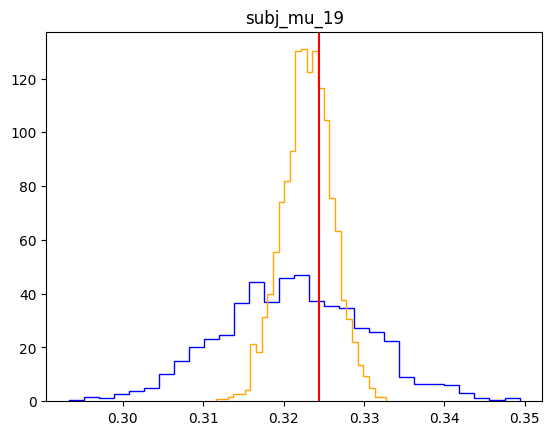

{'g_mu_mu': array([0]), 'g_mu_std': array([0.25]), 'subj_mu': array([ 2.77138678e-04, -7.23860173e-02, -2.79016576e-01, -3.22068919e-03,
       -9.45903661e-02, -1.20283841e-01, -3.79332795e-01, -1.22717995e-01,
       -6.01701446e-02, -1.61986865e-01,  1.58972770e-01,  4.35029326e-01,
        7.41705544e-02,  1.76875915e-01,  4.55703941e-01,  1.07692257e-01,
        3.85682406e-01, -2.25180293e-01, -3.42812526e-02,  3.24394753e-01])}
obs
torch.Size([1000, 1000, 20])


In [21]:
# tmp_dict = {'g_mu_mu': np.array(global_mean_mean, ndmin = 1),
#             'g_mu_std':np.array(global_mean_std, ndmin = 1),
#             'g_std_mu': np.array(global_std_mean, ndmin = 1),
#             'g_std_std': np.array(global_std_std, ndmin = 1),
#             'subj_std': np.array(subj_std, ndmin = 1),
#             'subj_mu': np.array(subj_mean, ndmin = 1),
#             }

tmp_dict = {'g_mu_mu': np.array(global_mean_mean, ndmin = 1),
            'g_mu_std': np.array(global_mean_std, ndmin = 1),
            'subj_mu': np.array(subj_mean, ndmin = 1),
            }

for key_ in svi_samples.keys():
    print(tmp_dict)
    #print(svi_samples[key_].numpy().shape[-1])
    print(key_)
    print(svi_samples[key_].shape)
    if key_ is not 'obs':
        for i in range(svi_samples[key_].numpy().shape[-1]):
            samples = svi_samples[key_].numpy().squeeze()
            hmc_samples = hmc_samples_new[key_].squeeze()
            shape_n = len(samples.shape)
            if shape_n == 2:
                tmp_samples = samples[:, i]
                tmp_hmc_samples = hmc_samples[:, i]
            else:
                tmp_samples = samples[:]
                tmp_hmc_samples = hmc_samples[:]
            plt.hist(tmp_samples, histtype = 'step', color = 'blue', bins = 30, density = True)
            plt.hist(tmp_hmc_samples, histtype = 'step', color = 'orange', bins = 30, density = True)
            print(tmp_dict[key_])
            print(tmp_dict[key_][i])
            plt.axvline(x = tmp_dict[key_][i], color = 'red')
            plt.title(key_ + '_' + str(i))
            plt.show()